# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json

# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definition
PAST_HISTORY = 48 # hours used to predict next values in future
FUTURE_TARGET = 13 # number of hours to predict 
STEP = 1
BATCH_SIZE = 32

path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_feat.csv")

path_save_pred_vals = "data/pred_vals.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

In [2]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))

## Load raw features

In [3]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH   Volume_ETH  \
0      1.609459e+12    736.42    739.00   729.33     734.07  27932.69884   
1      1.609463e+12    734.08    749.00   733.37     748.28  52336.18779   
2      1.609466e+12    748.27    749.00   742.27     744.06  33019.50100   
3      1.609470e+12    744.06    747.23   743.10     744.82  17604.80859   
4      1.609474e+12    744.87    747.09   739.30     742.29  18794.15424   
...             ...       ...       ...      ...        ...          ...   
19655  1.680217e+12   1784.47   1800.00  1781.84    1793.61  15006.95500   
19656  1.680221e+12   1793.60   1809.32  1789.42    1805.43  24915.35370   
19657  1.680224e+12   1805.42   1817.99  1800.00    1802.35  28743.78930   
19658  1.680228e+12   1802.35   1805.61  1799.39    1803.18  11827.32760   
19659  1.680232e+12   1803.18   1803.42  1802.64    1802.65    353.80350   

                  date_ETH  nb_time_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2021-01-01 00:00:00          0.0        2290.54729       2283.124479   
1      2021-01-01 01:00:00          1.0        2290.54729       2283.124479   
2      2021-01-01 02:00:00          2.0        2290.54729       2283.124479   
3      2021-01-01 03:00:00          3.0        2290.54729       2283.124479   
4      2021-01-01 04:00:00          4.0        2290.54729       2283.124479   
...                    ...          ...               ...               ...   
19655  2023-03-30 23:00:00      19655.0        1799.57250       1762.140000   
19656  2023-03-31 00:00:00      19656.0        1797.28000       1762.140000   
19657  2023-03-31 01:00:00      19657.0        1797.27250       1762.140000   
19658  2023-03-31 02:00:00      19658.0        1796.72250       1764.560000   
19659  2023-03-31 03:00:00      19659.0        1797.22500       1764.560000   

       ...  keep  Actual_num  Consensus_num  Previous_num  delta_event_pred  \
0      ...   NaN         NaN            NaN           NaN               NaN   
1      ...   NaN         NaN            NaN           NaN               NaN   
2      ...   NaN         NaN            NaN           NaN               NaN   
3      ...   NaN         NaN            NaN           NaN               NaN   
4      ...   NaN         NaN            NaN           NaN               NaN   
...    ...   ...         ...            ...           ...               ...   
19655  ...   NaN         NaN            NaN           NaN               NaN   
19656  ...   NaN         NaN            NaN           NaN               NaN   
19657  ...   NaN         NaN            NaN           NaN               NaN   
19658  ...   NaN         NaN            NaN           NaN               NaN   
19659  ...   NaN         NaN            NaN           NaN               NaN   

       event_pred  delta_event_real  event_real  day_off  date  
0             0.0               NaN         0.0      0.0   NaN  
1             0.0               NaN         0.0      0.0   NaN  
2             0.0               NaN         0.0      0.0   NaN  
3             0.0               NaN         0.0      0.0   NaN  
4             0.0               NaN         0.0      0.0   NaN  
...           ...               ...         ...      ...   ...  
19655         0.0               NaN         0.0      0.0   NaN  
19656         0.0               NaN         0.0      0.0   NaN  
19657         0.0               NaN         0.0      0.0   NaN  
19658         0.0               NaN         0.0      0.0   NaN  
19659         0.0               NaN         0.0      0.0   NaN  

[19660 rows x 138 columns]

In [4]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_ETH            1
vwap_z_score_BTC            1
ichi_tenkan_BTC             8
ichi_tenkan_ETH             8
max_high_h_ETH             13
max_high_h_BTC             13
chop_h_BTC                 13
chop_h_ETH                 13
rsi_h_BTC                  13
min_low_h_ETH              13
rsi_h_ETH                  13
min_low_h_BTC              13
ichi_cloud_a_BTC           25
ichi_kijun_ETH             25
ichi_kijun_BTC             25
ichi_cloud_a_ETH           25
ichi_tenkan_day_BTC       215
ichi_tenkan_day_ETH       215
rsi_d_ETH                 335
min_low_d_BTC             335
rsi_d_BTC                 335
max_high_d_ETH            335
min_low_d_ETH             335
max_high_d_BTC            335
chop_d_ETH                335
chop_d_BTC                335
ichi_kijun_day_ETH        623
ichi_cloud_a_day_ETH      623
ichi_kijun_day_BTC        623
ichi_cloud_a_day_BTC      623
dxy                      1109
fvx                      1117
spx                     

<AxesSubplot: >

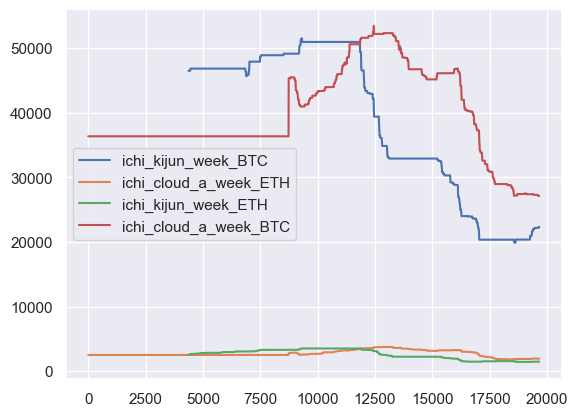

In [5]:
df_feat_raw[["ichi_kijun_week_BTC"   ,    
"ichi_cloud_a_week_ETH"   ,  
"ichi_kijun_week_ETH"    ,   
"ichi_cloud_a_week_BTC"]].plot()

### drop nan

In [6]:
print(df_feat_raw.shape)
df_feat = df_feat_raw.dropna(subset=["ichi_kijun_week_ETH"]).copy()
df_feat.reset_index(inplace=True)
df_feat.shape

(19660, 138)


(15293, 139)

In [7]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       15216
delta_event_real    15216
delta_event_pred    15216
Previous_num        15216
Actual_num          15216
Event               15216
Date                15216
Previous            15216
Consensus           15216
Actual              15216
Country             15216
Time (ET)           15216
keep                15216
date                15216
dtype: int64

on 15293 samples


In [8]:
df_feat

index          Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  \
0       4367  1.625180e+12   2128.88   2135.07  2104.88    2106.41   
1       4368  1.625184e+12   2106.41   2136.00  2096.00    2135.18   
2       4369  1.625188e+12   2135.50   2139.00  2084.04    2087.34   
3       4370  1.625191e+12   2087.45   2103.64  2082.00    2094.46   
4       4371  1.625195e+12   2094.45   2095.74  2033.96    2041.20   
...      ...           ...       ...       ...      ...        ...   
15288  19655  1.680217e+12   1784.47   1800.00  1781.84    1793.61   
15289  19656  1.680221e+12   1793.60   1809.32  1789.42    1805.43   
15290  19657  1.680224e+12   1805.42   1817.99  1800.00    1802.35   
15291  19658  1.680228e+12   1802.35   1805.61  1799.39    1803.18   
15292  19659  1.680232e+12   1803.18   1803.42  1802.64    1802.65   

        Volume_ETH             date_ETH  nb_time_ETH  ichi_cloud_a_ETH  ...  \
0      20782.46239  2021-07-01 23:00:00       4367.0         2188.2400  ...   
1      22888.95033  2021-07-02 00:00:00       4368.0         2188.2400  ...   
2      28744.05686  2021-07-02 01:00:00       4369.0         2188.2400  ...   
3      18099.07919  2021-07-02 02:00:00       4370.0         2189.4400  ...   
4      47236.16323  2021-07-02 03:00:00       4371.0         2192.3925  ...   
...            ...                  ...          ...               ...  ...   
15288  15006.95500  2023-03-30 23:00:00      19655.0         1799.5725  ...   
15289  24915.35370  2023-03-31 00:00:00      19656.0         1797.2800  ...   
15290  28743.78930  2023-03-31 01:00:00      19657.0         1797.2725  ...   
15291  11827.32760  2023-03-31 02:00:00      19658.0         1796.7225  ...   
15292    353.80350  2023-03-31 03:00:00      19659.0         1797.2250  ...   

       keep  Actual_num  Consensus_num  Previous_num  delta_event_pred  \
0       NaN         NaN            NaN           NaN               NaN   
1       NaN         NaN            NaN           NaN               NaN   
2       NaN         NaN            NaN           NaN               NaN   
3       NaN         NaN            NaN           NaN               NaN   
4       NaN         NaN            NaN           NaN               NaN   
...     ...         ...            ...           ...               ...   
15288   NaN         NaN            NaN           NaN               NaN   
15289   NaN         NaN            NaN           NaN               NaN   
15290   NaN         NaN            NaN           NaN               NaN   
15291   NaN         NaN            NaN           NaN               NaN   
15292   NaN         NaN            NaN           NaN               NaN   

       event_pred  delta_event_real  event_real  day_off  date  
0             0.0               NaN         0.0      0.0   NaN  
1             0.0               NaN         0.0      0.0   NaN  
2             0.0               NaN         0.0      0.0   NaN  
3             0.0               NaN         0.0      0.0   NaN  
4             0.0               NaN         0.0      0.0   NaN  
...           ...               ...         ...      ...   ...  
15288         0.0               NaN         0.0      0.0   NaN  
15289         0.0               NaN         0.0      0.0   NaN  
15290         0.0               NaN         0.0      0.0   NaN  
15291         0.0               NaN         0.0      0.0   NaN  
15292         0.0               NaN         0.0      0.0   NaN  

[15293 rows x 139 columns]

## Features Selection

### Propotional to the Price

In [9]:
list_col = df_feat.columns.to_list()
list_col

['index',
 'Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'nb_time_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_

In [10]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'nb_time_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [11]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH   Volume_ETH  \
0       2128.88   2135.07  2104.88    2106.41  20782.46239   
1       2106.41   2136.00  2096.00    2135.18  22888.95033   
2       2135.50   2139.00  2084.04    2087.34  28744.05686   
3       2087.45   2103.64  2082.00    2094.46  18099.07919   
4       2094.45   2095.74  2033.96    2041.20  47236.16323   
...         ...       ...      ...        ...          ...   
15288   1784.47   1800.00  1781.84    1793.61  15006.95500   
15289   1793.60   1809.32  1789.42    1805.43  24915.35370   
15290   1805.42   1817.99  1800.00    1802.35  28743.78930   
15291   1802.35   1805.61  1799.39    1803.18  11827.32760   
15292   1803.18   1803.42  1802.64    1802.65    353.80350   

                  date_ETH  nb_time_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2021-07-01 23:00:00       4367.0         2188.2400          2174.775   
1      2021-07-02 00:00:00       4368.0         2188.2400          2174.775   
2      2021-07-02 01:00:00       4369.0         2188.2400          2174.775   
3      2021-07-02 02:00:00       4370.0         2189.4400          2174.775   
4      2021-07-02 03:00:00       4371.0         2192.3925          2174.775   
...                    ...          ...               ...               ...   
15288  2023-03-30 23:00:00      19655.0         1799.5725          1762.140   
15289  2023-03-31 00:00:00      19656.0         1797.2800          1762.140   
15290  2023-03-31 01:00:00      19657.0         1797.2725          1762.140   
15291  2023-03-31 02:00:00      19658.0         1796.7225          1764.560   
15292  2023-03-31 03:00:00      19659.0         1797.2250          1764.560   

       ichi_kijun_ETH  ...   vwap_m_ETH  vwap_3m_ETH  vwap_6m_ETH  \
0            2177.520  ...  1997.879913  1997.879913  1997.879913   
1            2177.520  ...  1997.892763  1997.892763  1997.892763   
2            2174.525  ...  1997.906443  1997.906443  1997.906443   
3            2170.405  ...  1997.914232  1997.914232  1997.914232   
4            2149.315  ...  1997.926804  1997.926804  1997.926804   
...               ...  ...          ...          ...          ...   
15288        1796.345  ...  1459.960364  2144.493764  2093.380085   
15289        1796.345  ...  1460.011403  2144.479179  2093.368484   
15290        1796.345  ...  1460.080685  2144.463602  2093.355349   
15291        1796.345  ...  1460.094662  2144.456887  2093.349868   
15292        1796.345  ...  1460.035218  2144.458550  2093.349704   

        vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH    supply_ETH  \
0      1997.879913   1997.879913          0.154972  0.051524  1.166929e+08   
1      1997.892763   1997.892763          0.196056  0.064298  1.167074e+08   
2      1997.906443   1997.906443          0.127732  0.042846  1.167074e+08   
3      1997.914232   1997.914232          0.137906  0.046096  1.167074e+08   
4      1997.926804   1997.926804          0.061819  0.021200  1.167074e+08   
...            ...           ...               ...       ...           ...   
15288  1592.555510   2093.380085         -0.309474 -0.167132  1.204260e+08   
15289  1592.486925   2093.368484         -0.297265 -0.159485  1.204260e+08   
15290  1592.426278   2093.355349         -0.300437 -0.161459  1.204260e+08   
15291  1592.368357   2093.349868         -0.299580 -0.160921  1.204260e+08   
15292  1592.288572   2093.349704         -0.300133 -0.161262  1.204260e+08   

       act_addr_ETH  market_dom_ETH  
0          527404.0       17.798166  
1          501748.0       17.561982  
2          501748.0       17.561982  
3          501748.0       17.561982  
4          501748.0       17.561982  
...             ...             ...  
15288      512738.0       19.936990  
15289      512738.0       19.936990  
15290      512738.0       19.936990  
15291      512738.0       19.936990  
15292      512738.0       19.936990  

[15293 rows x 47 columns]

In [12]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [13]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'nb_time_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [14]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [15]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB',
 'High_BNB',
 'Low_BNB',
 'Close_BNB',
 'Volume_BNB',
 'date_BNB',
 'nb_time_BNB']

In [16]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

### Not proportional to the Price 

In [17]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'dxy',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'hour',
 'hour_cos',
 'hour_sin',
 'index',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nb_time_BNB',
 'nb_time_BTC',
 'nb_time_ETH',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'spx',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_scor

In [18]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    'dxy',
    'spx',
    'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    'month_cos',
    'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [19]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +    
    list_col_other
)


# selection
list_col_select = list_col_select_global
print("num features : ", len(list_col_select))

num features :  104


In [20]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [21]:
df_feat["event_real"].describe()

count    15293.000000
mean        -0.000719
std          0.050496
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: event_real, dtype: float64

In [22]:
df_feat["event_real"].value_counts()

 0.0    15254
-1.0       25
 1.0       14
Name: event_real, dtype: int64

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [23]:
df_feat.shape[0]

15293

In [24]:
TRAIN_SPLIT = round(0.99 * df_feat.shape[0])
TRAIN_SPLIT

15140

In [25]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

index          Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  \
0       4367  1.625180e+12   2128.88   2135.07  2104.88    2106.41   
1       4368  1.625184e+12   2106.41   2136.00  2096.00    2135.18   
2       4369  1.625188e+12   2135.50   2139.00  2084.04    2087.34   
3       4370  1.625191e+12   2087.45   2103.64  2082.00    2094.46   
4       4371  1.625195e+12   2094.45   2095.74  2033.96    2041.20   
...      ...           ...       ...       ...      ...        ...   
15288  19655  1.680217e+12   1784.47   1800.00  1781.84    1793.61   
15289  19656  1.680221e+12   1793.60   1809.32  1789.42    1805.43   
15290  19657  1.680224e+12   1805.42   1817.99  1800.00    1802.35   
15291  19658  1.680228e+12   1802.35   1805.61  1799.39    1803.18   
15292  19659  1.680232e+12   1803.18   1803.42  1802.64    1802.65   

        Volume_ETH             date_ETH  nb_time_ETH  ichi_cloud_a_ETH  ...  \
0      20782.46239  2021-07-01 23:00:00       4367.0         2188.2400  ...   
1      22888.95033  2021-07-02 00:00:00       4368.0         2188.2400  ...   
2      28744.05686  2021-07-02 01:00:00       4369.0         2188.2400  ...   
3      18099.07919  2021-07-02 02:00:00       4370.0         2189.4400  ...   
4      47236.16323  2021-07-02 03:00:00       4371.0         2192.3925  ...   
...            ...                  ...          ...               ...  ...   
15288  15006.95500  2023-03-30 23:00:00      19655.0         1799.5725  ...   
15289  24915.35370  2023-03-31 00:00:00      19656.0         1797.2800  ...   
15290  28743.78930  2023-03-31 01:00:00      19657.0         1797.2725  ...   
15291  11827.32760  2023-03-31 02:00:00      19658.0         1796.7225  ...   
15292    353.80350  2023-03-31 03:00:00      19659.0         1797.2250  ...   

       Actual_num  Consensus_num  Previous_num  delta_event_pred  event_pred  \
0             NaN            NaN           NaN               NaN         0.0   
1             NaN            NaN           NaN               NaN         0.0   
2             NaN            NaN           NaN               NaN         0.0   
3             NaN            NaN           NaN               NaN         0.0   
4             NaN            NaN           NaN               NaN         0.0   
...           ...            ...           ...               ...         ...   
15288         NaN            NaN           NaN               NaN         0.0   
15289         NaN            NaN           NaN               NaN         0.0   
15290         NaN            NaN           NaN               NaN         0.0   
15291         NaN            NaN           NaN               NaN         0.0   
15292         NaN            NaN           NaN               NaN         0.0   

       delta_event_real  event_real  day_off  date  train  
0                   NaN         0.0      0.0   NaN   True  
1                   NaN         0.0      0.0   NaN   True  
2                   NaN         0.0      0.0   NaN   True  
3                   NaN         0.0      0.0   NaN   True  
4                   NaN         0.0      0.0   NaN   True  
...                 ...         ...      ...   ...    ...  
15288               NaN         0.0      0.0   NaN  False  
15289               NaN         0.0      0.0   NaN  False  
15290               NaN         0.0      0.0   NaN  False  
15291               NaN         0.0      0.0   NaN  False  
15292               NaN         0.0      0.0   NaN  False  

[15293 rows x 140 columns]

In [26]:
df_feat[df_feat["train"] == True]

index          Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  \
0       4367  1.625180e+12   2128.88   2135.07  2104.88    2106.41   
1       4368  1.625184e+12   2106.41   2136.00  2096.00    2135.18   
2       4369  1.625188e+12   2135.50   2139.00  2084.04    2087.34   
3       4370  1.625191e+12   2087.45   2103.64  2082.00    2094.46   
4       4371  1.625195e+12   2094.45   2095.74  2033.96    2041.20   
...      ...           ...       ...       ...      ...        ...   
15136  19503  1.679670e+12   1763.11   1771.14  1753.00    1767.01   
15137  19504  1.679674e+12   1767.00   1770.01  1760.30    1762.76   
15138  19505  1.679677e+12   1762.76   1764.47  1726.40    1737.51   
15139  19506  1.679681e+12   1737.51   1767.06  1736.08    1756.03   
15140  19507  1.679684e+12   1756.04   1767.12  1751.85    1763.86   

        Volume_ETH             date_ETH  nb_time_ETH  ichi_cloud_a_ETH  ...  \
0      20782.46239  2021-07-01 23:00:00       4367.0         2188.2400  ...   
1      22888.95033  2021-07-02 00:00:00       4368.0         2188.2400  ...   
2      28744.05686  2021-07-02 01:00:00       4369.0         2188.2400  ...   
3      18099.07919  2021-07-02 02:00:00       4370.0         2189.4400  ...   
4      47236.16323  2021-07-02 03:00:00       4371.0         2192.3925  ...   
...            ...                  ...          ...               ...  ...   
15136  40962.97410  2023-03-24 15:00:00      19503.0         1754.8850  ...   
15137  21022.14040  2023-03-24 16:00:00      19504.0         1769.5125  ...   
15138  63428.44150  2023-03-24 17:00:00      19505.0         1791.4425  ...   
15139  43008.08040  2023-03-24 18:00:00      19506.0         1791.4425  ...   
15140  19578.76390  2023-03-24 19:00:00      19507.0         1791.4425  ...   

       Actual_num  Consensus_num  Previous_num  delta_event_pred  event_pred  \
0             NaN            NaN           NaN               NaN         0.0   
1             NaN            NaN           NaN               NaN         0.0   
2             NaN            NaN           NaN               NaN         0.0   
3             NaN            NaN           NaN               NaN         0.0   
4             NaN            NaN           NaN               NaN         0.0   
...           ...            ...           ...               ...         ...   
15136         NaN            NaN           NaN               NaN         0.0   
15137         NaN            NaN           NaN               NaN         0.0   
15138         NaN            NaN           NaN               NaN         0.0   
15139         NaN            NaN           NaN               NaN         0.0   
15140         NaN            NaN           NaN               NaN         0.0   

       delta_event_real  event_real  day_off  date  train  
0                   NaN         0.0      0.0   NaN   True  
1                   NaN         0.0      0.0   NaN   True  
2                   NaN         0.0      0.0   NaN   True  
3                   NaN         0.0      0.0   NaN   True  
4                   NaN         0.0      0.0   NaN   True  
...                 ...         ...      ...   ...    ...  
15136               NaN         0.0      0.0   NaN   True  
15137               NaN         0.0      0.0   NaN   True  
15138               NaN         0.0      0.0   NaN   True  
15139               NaN         0.0      0.0   NaN   True  
15140               NaN         0.0      0.0   NaN   True  

[15141 rows x 140 columns]

In [27]:
df_feat[df_feat["train"] == False]

index          Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  \
15141  19508  1.679688e+12   1763.86   1764.64  1739.56    1748.62   
15142  19509  1.679692e+12   1748.61   1750.45  1728.47    1745.21   
15143  19510  1.679695e+12   1745.20   1749.01  1741.63    1743.26   
15144  19511  1.679699e+12   1743.27   1753.87  1742.22    1749.57   
15145  19512  1.679702e+12   1749.57   1758.41  1746.48    1756.33   
...      ...           ...       ...       ...      ...        ...   
15288  19655  1.680217e+12   1784.47   1800.00  1781.84    1793.61   
15289  19656  1.680221e+12   1793.60   1809.32  1789.42    1805.43   
15290  19657  1.680224e+12   1805.42   1817.99  1800.00    1802.35   
15291  19658  1.680228e+12   1802.35   1805.61  1799.39    1803.18   
15292  19659  1.680232e+12   1803.18   1803.42  1802.64    1802.65   

       Volume_ETH             date_ETH  nb_time_ETH  ichi_cloud_a_ETH  ...  \
15141  28814.5473  2023-03-24 20:00:00      19508.0         1791.4425  ...   
15142  33987.5823  2023-03-24 21:00:00      19509.0         1791.4425  ...   
15143  12927.2989  2023-03-24 22:00:00      19510.0         1791.4425  ...   
15144  16307.1125  2023-03-24 23:00:00      19511.0         1791.4875  ...   
15145  13545.4908  2023-03-25 00:00:00      19512.0         1793.0025  ...   
...           ...                  ...          ...               ...  ...   
15288  15006.9550  2023-03-30 23:00:00      19655.0         1799.5725  ...   
15289  24915.3537  2023-03-31 00:00:00      19656.0         1797.2800  ...   
15290  28743.7893  2023-03-31 01:00:00      19657.0         1797.2725  ...   
15291  11827.3276  2023-03-31 02:00:00      19658.0         1796.7225  ...   
15292    353.8035  2023-03-31 03:00:00      19659.0         1797.2250  ...   

       Actual_num  Consensus_num  Previous_num  delta_event_pred  event_pred  \
15141         NaN            NaN           NaN               NaN         0.0   
15142         NaN            NaN           NaN               NaN         0.0   
15143         NaN            NaN           NaN               NaN         0.0   
15144         NaN            NaN           NaN               NaN         0.0   
15145         NaN            NaN           NaN               NaN         0.0   
...           ...            ...           ...               ...         ...   
15288         NaN            NaN           NaN               NaN         0.0   
15289         NaN            NaN           NaN               NaN         0.0   
15290         NaN            NaN           NaN               NaN         0.0   
15291         NaN            NaN           NaN               NaN         0.0   
15292         NaN            NaN           NaN               NaN         0.0   

       delta_event_real  event_real  day_off  date  train  
15141               NaN         0.0      0.0   NaN  False  
15142               NaN         0.0      0.0   NaN  False  
15143               NaN         0.0      0.0   NaN  False  
15144               NaN         0.0      0.0   NaN  False  
15145               NaN         0.0      0.0   NaN  False  
...                 ...         ...      ...   ...    ...  
15288               NaN         0.0      0.0   NaN  False  
15289               NaN         0.0      0.0   NaN  False  
15290               NaN         0.0      0.0   NaN  False  
15291               NaN         0.0      0.0   NaN  False  
15292               NaN         0.0      0.0   NaN  False  

[152 rows x 140 columns]

In [28]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [29]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [30]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
    ) 
    for col in list_col_select ]

In [31]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15080, 48, 104) (15080, 13)
(91, 48, 104) (91, 13)


In [ ]:
FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [32]:
X_train

array([[[0.95500213, 0.96518956, 0.96799597, ..., 0.        ,
         0.        , 0.        ],
        [0.96804585, 0.95500213, 0.96841762, ..., 0.        ,
         0.        , 0.        ],
        [0.94635619, 0.96819093, 0.96977775, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [1.00681882, 1.00893157, 1.01046852, ..., 0.        ,
         0.        , 0.        ],
        [0.99350308, 1.00681882, 1.00984739, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 0.99378417, 1.0019586 , ..., 0.        ,
         0.        , 0.        ]],

       [[0.95877395, 0.94585517, 0.95914216, ..., 0.        ,
         0.        , 0.        ],
        [0.93729204, 0.95891764, 0.96048927, ..., 0.        ,
         0.        , 0.        ],
        [0.94048918, 0.93734143, 0.94461134, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.98398736, 0.99717556, 1.00017512, ..., 0.        ,
         0.        , 0.        ],
        [0.9

In [33]:
seq_y

array([1.00076164, 1.00182131, 0.99061748, 0.98616906, 0.98652781,
       0.98765923, 0.98765923, 0.98037398, 0.97308873, 0.97523567,
       0.97289004, 0.95895424, 0.96917566])

In [34]:
y_train

array([[1.00967057, 1.00048512, 0.99583798, ..., 1.05341712, 1.05926571,
        1.05681293],
       [0.99090252, 0.98629989, 0.99140095, ..., 1.04912011, 1.04669082,
        1.03601723],
       [0.99535512, 1.00050301, 1.00135948, ..., 1.0563005 , 1.0455289 ,
        1.0498022 ],
       ...,
       [0.9956741 , 0.99974618, 1.00050763, ..., 0.97284174, 0.97498814,
        0.9726431 ],
       [1.00408978, 1.00485453, 1.00591854, ..., 0.97922416, 0.97686894,
        0.96287614],
       [1.00076164, 1.00182131, 0.99061748, ..., 0.97289004, 0.95895424,
        0.96917566]])

In [35]:
seq_y

array([1.00076164, 1.00182131, 0.99061748, 0.98616906, 0.98652781,
       0.98765923, 0.98765923, 0.98037398, 0.97308873, 0.97523567,
       0.97289004, 0.95895424, 0.96917566])

In [36]:
y_train

array([[1.00967057, 1.00048512, 0.99583798, ..., 1.05341712, 1.05926571,
        1.05681293],
       [0.99090252, 0.98629989, 0.99140095, ..., 1.04912011, 1.04669082,
        1.03601723],
       [0.99535512, 1.00050301, 1.00135948, ..., 1.0563005 , 1.0455289 ,
        1.0498022 ],
       ...,
       [0.9956741 , 0.99974618, 1.00050763, ..., 0.97284174, 0.97498814,
        0.9726431 ],
       [1.00408978, 1.00485453, 1.00591854, ..., 0.97922416, 0.97686894,
        0.96287614],
       [1.00076164, 1.00182131, 0.99061748, ..., 0.97289004, 0.95895424,
        0.96917566]])

In [37]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [38]:
X_train.shape

(15080, 48, 104)

In [39]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(15080, 48, 104) (15080, 13)
(91, 48, 104) (91, 13)


## Standardization

In [147]:
X_train.shape

(15080, 48, 104)

In [146]:
X_train.reshape(-1,X_train.shape[-1]).shape

(723840, 104)

In [40]:
scaler = StandardScaler()
X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

In [142]:
scaler.scale_.shape

(104,)

In [136]:
np.sqrt(scaler.var_[0])

0.04266397744075081

In [150]:
y_train.ravel().shape

(196040,)

In [149]:
y_train.reshape(-1,y_train.shape[-1]).shape

(15080, 13)

In [155]:
y_train.ravel().reshape(-1,1).shape

(196040, 1)

In [158]:
scaler_y = StandardScaler()
y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

In [159]:
scaler_y.scale_

array([0.02270182])

In [161]:
scaler_y.scale_[0]*np.sqrt(0.5)

0.01605260894833099

In [42]:
y_train

array([[1.00967057, 1.00048512, 0.99583798, ..., 1.05341712, 1.05926571,
        1.05681293],
       [0.99090252, 0.98629989, 0.99140095, ..., 1.04912011, 1.04669082,
        1.03601723],
       [0.99535512, 1.00050301, 1.00135948, ..., 1.0563005 , 1.0455289 ,
        1.0498022 ],
       ...,
       [0.9956741 , 0.99974618, 1.00050763, ..., 0.97284174, 0.97498814,
        0.9726431 ],
       [1.00408978, 1.00485453, 1.00591854, ..., 0.97922416, 0.97686894,
        0.96287614],
       [1.00076164, 1.00182131, 0.99061748, ..., 0.97289004, 0.95895424,
        0.96917566]])

In [43]:
np.mean(y_train_sca)

-1.2996799447041409e-14

In [44]:
np.std(y_train_sca)

0.9999999999999996

### Check unscaling

In [45]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    2106.41   2128.88   2135.07  2104.88         2188.2400          2174.775   
1    2135.18   2106.41   2136.00  2096.00         2188.2400          2174.775   
2    2087.34   2135.50   2139.00  2084.04         2188.2400          2174.775   
3    2094.46   2087.45   2103.64  2082.00         2189.4400          2174.775   
4    2041.20   2094.45   2095.74  2033.96         2192.3925          2174.775   
5    2054.86   2041.19   2058.85  2035.61         2203.5250          2174.775   
6    2032.84   2054.86   2058.77  2023.41         2211.6375          2180.675   
7    2034.03   2032.92   2041.86  2018.50         2210.8925          2185.445   
8    2061.49   2034.35   2070.00  2028.98         2210.8925          2185.445   
9    2060.50   2061.49   2080.46  2051.48         2203.1750          2186.930   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0        2177.520         2107.755              2793.485   
1        2177.520         2107.755              2793.485   
2        2174.525         2107.755              2793.485   
3        2170.405         2107.755              2793.485   
4        2149.315         2086.980              2793.485   
5        2134.385         2086.980              2793.485   
6        2129.110         2081.705              2793.485   
7        2126.655         2078.750              2793.485   
8        2126.655         2078.750              2793.485   
9        2094.295         2078.750              2793.485   

   ichi_cloud_b_day_ETH  ...  hour_sin  weekday_cos  weekday_sin  \
0               3050.73  ... -0.258819    -0.900969     0.433884   
1               3050.73  ...  0.000000    -0.900969    -0.433884   
2               3050.73  ...  0.258819    -0.900969    -0.433884   
3               3050.73  ...  0.500000    -0.900969    -0.433884   
4               3050.73  ...  0.707107    -0.900969    -0.433884   
5               3050.73  ...  0.866025    -0.900969    -0.433884   
6               3050.73  ...  0.965926    -0.900969    -0.433884   
7               3050.73  ...  1.000000    -0.900969    -0.433884   
8               3050.73  ...  0.965926    -0.900969    -0.433884   
9               3050.73  ...  0.866025    -0.900969    -0.433884   

   day_in_month_cos  day_in_month_sin  month_cos  month_sin  day_off  \
0          0.979530          0.201299  -0.866025       -0.5      0.0   
1          0.918958          0.394356  -0.866025       -0.5      0.0   
2          0.918958          0.394356  -0.866025       -0.5      0.0   
3          0.918958          0.394356  -0.866025       -0.5      0.0   
4          0.918958          0.394356  -0.866025       -0.5      0.0   
5          0.918958          0.394356  -0.866025       -0.5      0.0   
6          0.918958          0.394356  -0.866025       -0.5      0.0   
7          0.918958          0.394356  -0.866025       -0.5      0.0   
8          0.918958          0.394356  -0.866025       -0.5      0.0   
9          0.918958          0.394356  -0.866025       -0.5      0.0   

   event_pred  event_real  
0         0.0         0.0  
1         0.0         0.0  
2         0.0         0.0  
3         0.0         0.0  
4         0.0         0.0  
5         0.0         0.0  
6         0.0         0.0  
7         0.0         0.0  
8         0.0         0.0  
9         0.0         0.0  

[10 rows x 104 columns]

In [46]:
df_feat["Close_ETH"].iloc[0:10]

0    2106.41
1    2135.18
2    2087.34
3    2094.46
4    2041.20
5    2054.86
6    2032.84
7    2034.03
8    2061.49
9    2060.50
Name: Close_ETH, dtype: float64

In [47]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [48]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [2106.41 2135.18 2087.34 2094.46 2041.2  2054.86 2032.84 2034.03 2061.49
 2060.5 ]
X_train_raw:      [2106.41 2135.18 2087.34 2094.46 2041.2  2054.86 2032.84 2034.03 2061.49
 2060.5 ]


In [49]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
X test         :  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
unscaled to raw:  [1748.62 1745.21 1743.26 1749.57 1756.33 1753.88 1758.66 1756.   1753.37
 1744.05]
X_test_raw     :  [1748.62 1745.21 1743.26 1749.57 1756.33 1753.88 1758.66 1756.   1753.37
 1744.05]


## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [50]:
X_train_sca.shape

(15080, 48, 104)

In [51]:
X_train_sca[:,-1,:].shape

(15080, 104)

In [52]:
y_train_sca[:,0][:, np.newaxis]

array([[ 1.11582909],
       [-1.05518493],
       [-0.54012594],
       ...,
       [-0.50322729],
       [ 0.47026445],
       [ 0.08527896]])

In [53]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(15080, 105)

In [54]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

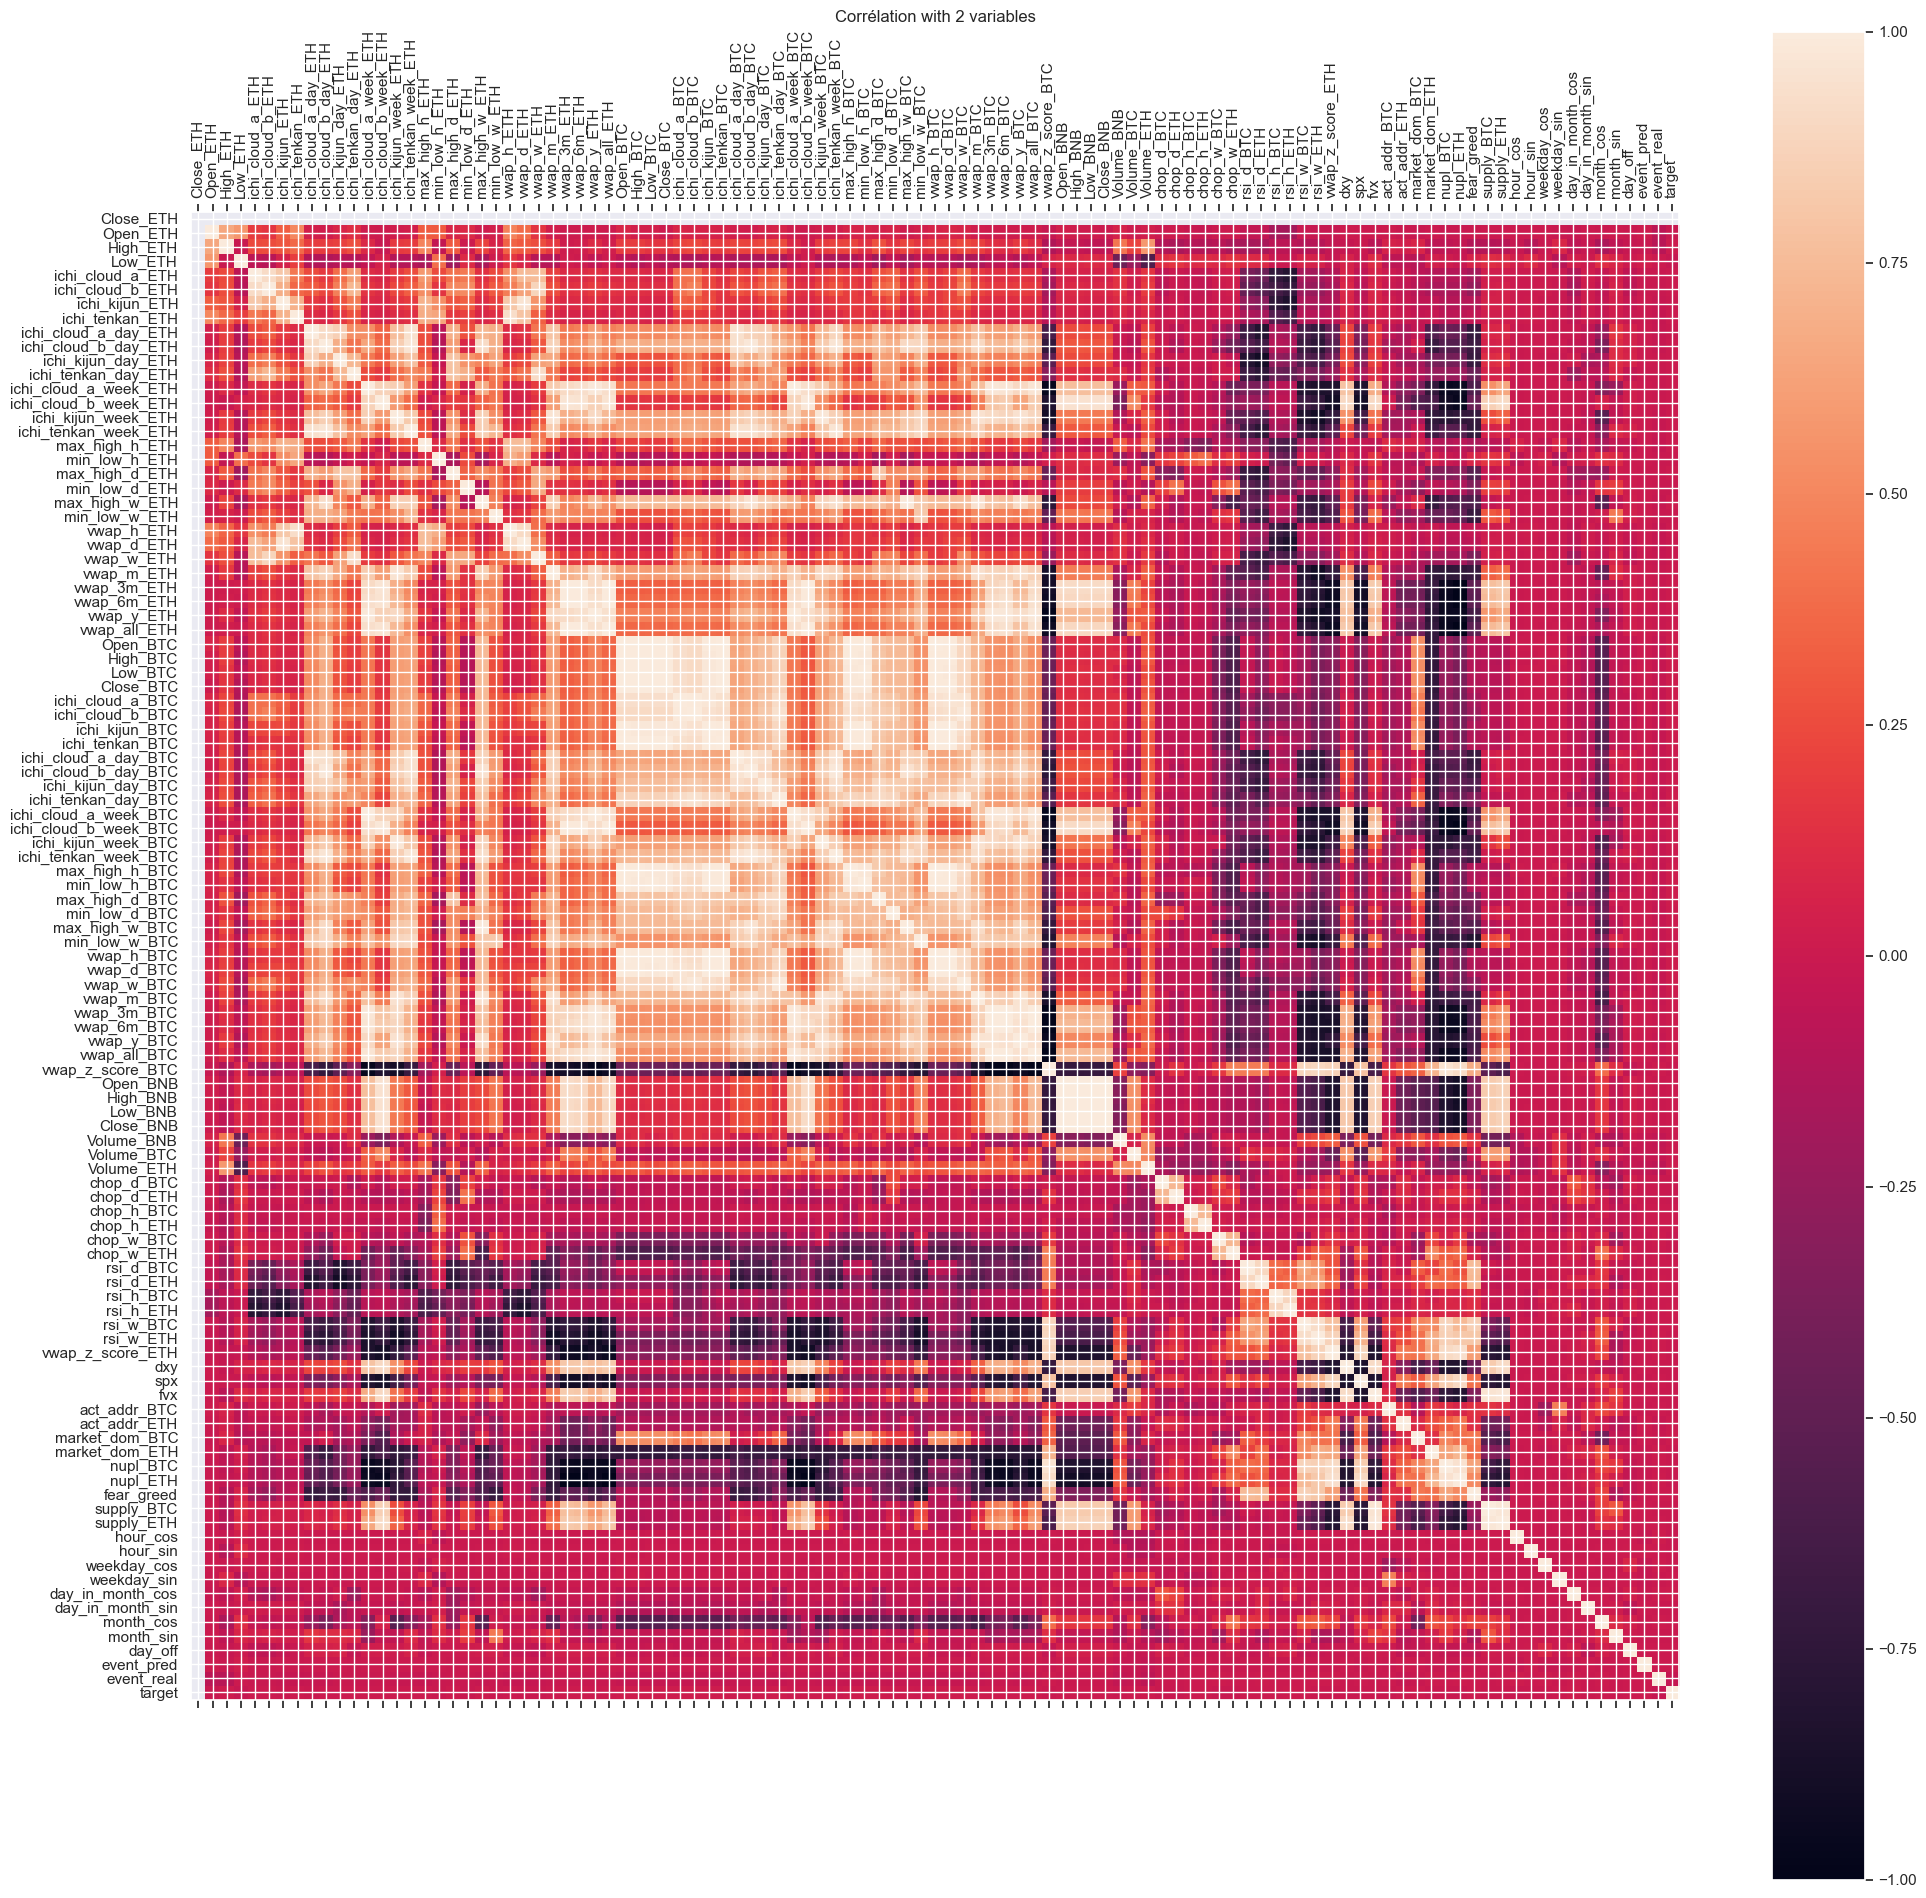

In [55]:

nb_plot = 104
# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
    columns=list_col_select[:nb_plot] + ['target'])

# Calculer la matrice de corrélation
corr_matrix = df.corr()

# Afficher la matrice de corrélation
fig, ax = plt.subplots(figsize=(24, 24))
im = ax.matshow(corr_matrix)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Corrélation with 2 variables')
fig.colorbar(im)
plt.show()


In [56]:
y_train

array([[1.00967057, 1.00048512, 0.99583798, ..., 1.05341712, 1.05926571,
        1.05681293],
       [0.99090252, 0.98629989, 0.99140095, ..., 1.04912011, 1.04669082,
        1.03601723],
       [0.99535512, 1.00050301, 1.00135948, ..., 1.0563005 , 1.0455289 ,
        1.0498022 ],
       ...,
       [0.9956741 , 0.99974618, 1.00050763, ..., 0.97284174, 0.97498814,
        0.9726431 ],
       [1.00408978, 1.00485453, 1.00591854, ..., 0.97922416, 0.97686894,
        0.96287614],
       [1.00076164, 1.00182131, 0.99061748, ..., 0.97289004, 0.95895424,
        0.96917566]])

In [57]:
y_train_sca

array([[ 1.11582909,  0.03551989, -0.28198808, ...,  1.8717611 ,
         1.98726427,  1.82849007],
       [-1.05518493, -1.11968783, -0.57744779, ...,  1.72052199,
         1.56378875,  1.15595643],
       [-0.54012594,  0.0369769 ,  0.08568568, ...,  1.97324575,
         1.52465958,  1.60176282],
       ...,
       [-0.50322729, -0.02465674,  0.02896164, ..., -0.96420231,
        -0.85089252, -0.89356465],
       [ 0.47026445,  0.39135371,  0.38927119, ..., -0.73956404,
        -0.78755407, -1.20942842],
       [ 0.08527896,  0.14433632, -0.62961861, ..., -0.96250246,
        -1.39085501, -1.00570175]])

## Autoencoder

In [58]:
X_train.shape

(15080, 48, 104)

### Model creation

In [59]:
def plot_train_history(history, title, saveFolder=False):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        plt.savefig(os.path.join(saveFolder, f"output_{title}.jpg")) 
    plt.show()

### Training

Training: units 16 - enc_dim 12 - drop 0.05 ...
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 16)          7744      
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 dense (Dense)               (None, None, 12)          204       
                                                                 
Total params: 7,948
Trainable params: 7,948
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_______________________________________

2023-04-04 16:41:16.987892: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


472/472 [==============================] - 22s 41ms/step - loss: 0.5009 - val_loss: 0.3161
Epoch 2/150
472/472 [==============================] - 18s 38ms/step - loss: 0.2913 - val_loss: 0.2376
Epoch 3/150
472/472 [==============================] - 18s 38ms/step - loss: 0.2499 - val_loss: 0.2147
Epoch 4/150
472/472 [==============================] - 18s 38ms/step - loss: 0.2235 - val_loss: 0.2027
Epoch 5/150
472/472 [==============================] - 18s 38ms/step - loss: 0.2073 - val_loss: 0.1896
Epoch 6/150
472/472 [==============================] - 18s 38ms/step - loss: 0.1965 - val_loss: 0.1634
Epoch 7/150
472/472 [==============================] - 18s 38ms/step - loss: 0.1863 - val_loss: 0.1515
Epoch 8/150
472/472 [==============================] - 18s 37ms/step - loss: 0.1796 - val_loss: 0.1432
Epoch 9/150
472/472 [==============================] - 18s 38ms/step - loss: 0.1753 - val_loss: 0.1335
Epoch 10/150
472/472 [==============================] - 18s 38ms/step - loss: 0.1715 

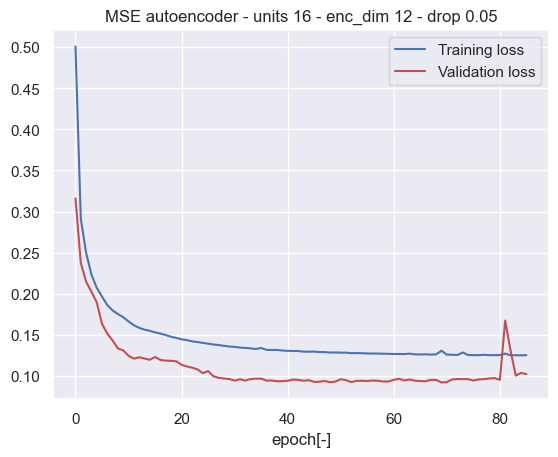

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u16_e12_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u16_e12_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u16_e12_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u16_e12_d0.05/assets


Training: units 16 - enc_dim 16 - drop 0.25 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 16)          7744      
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 dense (Dense)               (None, None, 16)          272       
                                                                 
Total params: 8,016
Trainable params: 8,016
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              

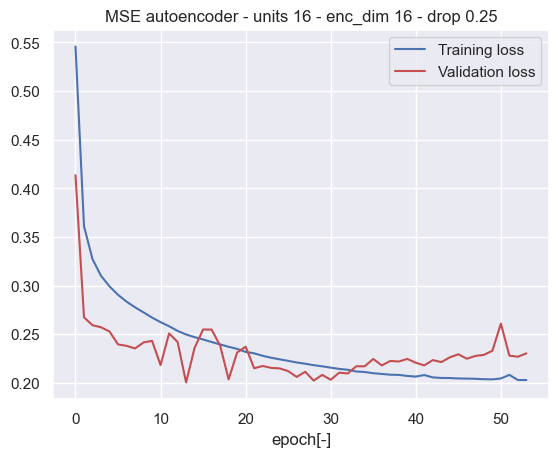

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u16_e16_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u16_e16_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u16_e16_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u16_e16_d0.25/assets


Training: units 16 - enc_dim 16 - drop 0.05 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 16)          7744      
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 dense (Dense)               (None, None, 16)          272       
                                                                 
Total params: 8,016
Trainable params: 8,016
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              

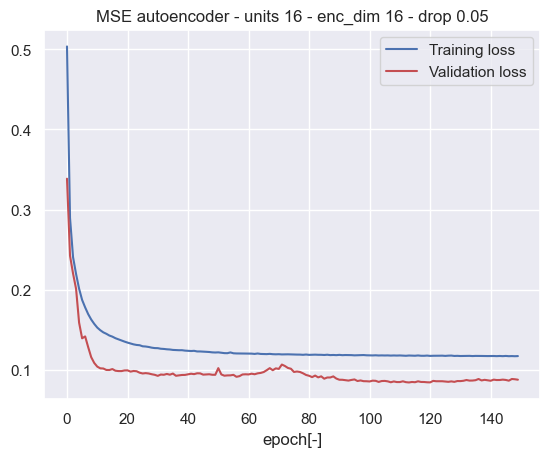

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u16_e16_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u16_e16_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u16_e16_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u16_e16_d0.05/assets


Training: units 32 - enc_dim 4 - drop 0.25 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 32)          17536     
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 dense (Dense)               (None, None, 4)           132       
                                                                 
Total params: 17,668
Trainable params: 17,668
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape             

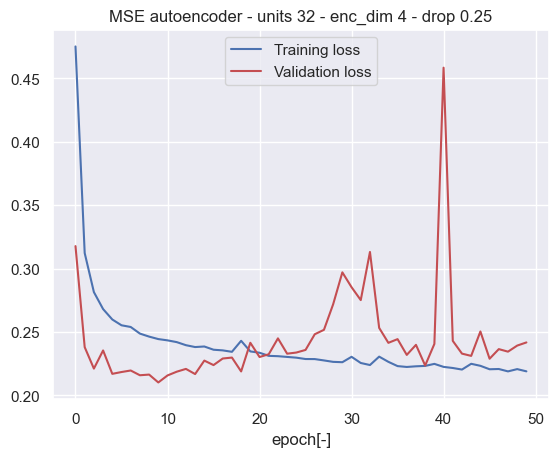

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u32_e4_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u32_e4_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u32_e4_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u32_e4_d0.25/assets


Training: units 32 - enc_dim 4 - drop 0.05 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 32)          17536     
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 dense (Dense)               (None, None, 4)           132       
                                                                 
Total params: 17,668
Trainable params: 17,668
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape             

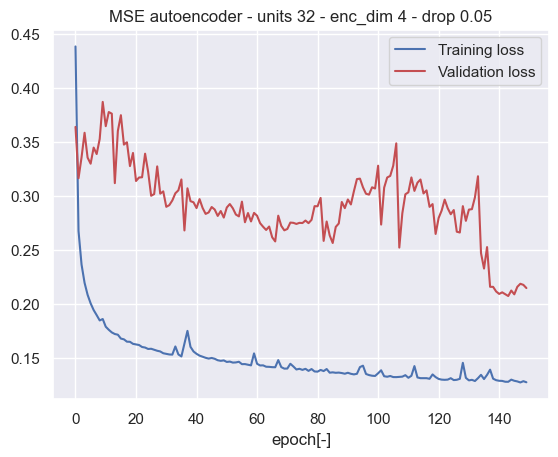

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u32_e4_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u32_e4_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u32_e4_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u32_e4_d0.05/assets


Training: units 32 - enc_dim 8 - drop 0.25 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 32)          17536     
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 dense (Dense)               (None, None, 8)           264       
                                                                 
Total params: 17,800
Trainable params: 17,800
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape             

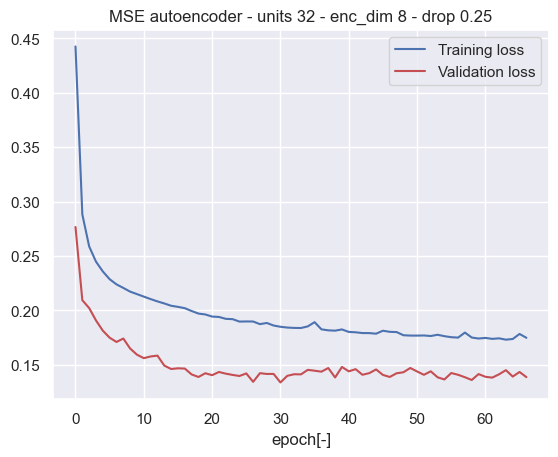

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u32_e8_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u32_e8_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u32_e8_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u32_e8_d0.25/assets


Training: units 32 - enc_dim 8 - drop 0.05 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 32)          17536     
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 dense (Dense)               (None, None, 8)           264       
                                                                 
Total params: 17,800
Trainable params: 17,800
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape             

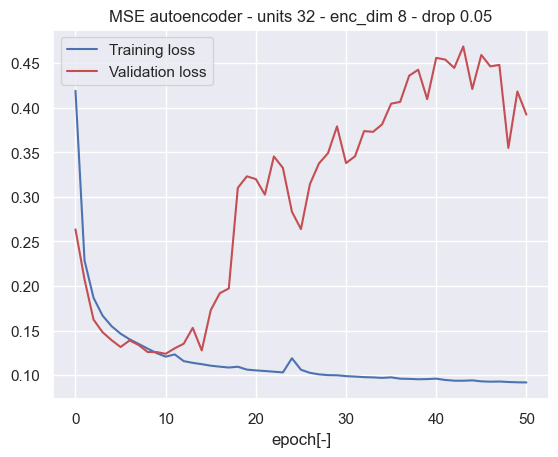

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u32_e8_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u32_e8_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u32_e8_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u32_e8_d0.05/assets


Training: units 32 - enc_dim 12 - drop 0.25 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 32)          17536     
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 dense (Dense)               (None, None, 12)          396       
                                                                 
Total params: 17,932
Trainable params: 17,932
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape            

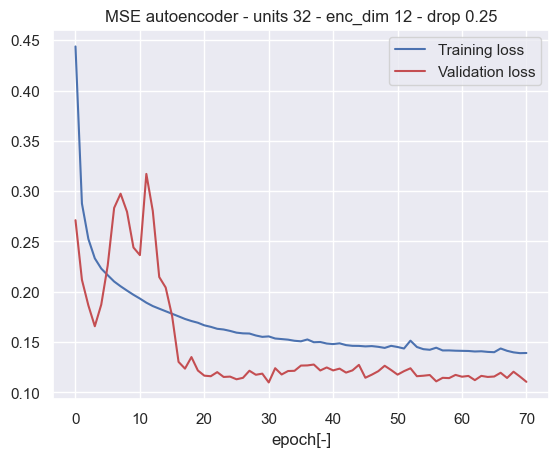

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u32_e12_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u32_e12_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u32_e12_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u32_e12_d0.25/assets


Training: units 32 - enc_dim 12 - drop 0.05 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 32)          17536     
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 dense (Dense)               (None, None, 12)          396       
                                                                 
Total params: 17,932
Trainable params: 17,932
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape            

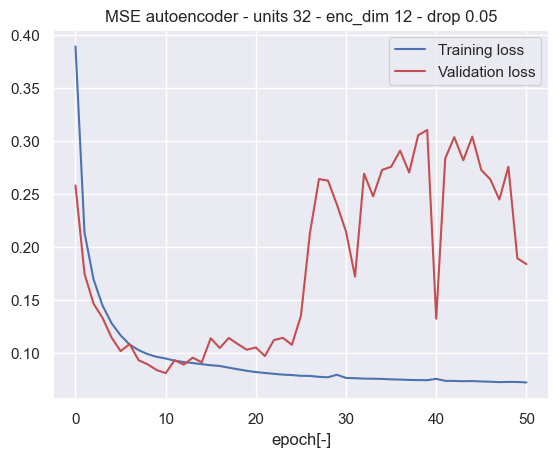

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u32_e12_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u32_e12_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u32_e12_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u32_e12_d0.05/assets


Training: units 32 - enc_dim 16 - drop 0.25 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 32)          17536     
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 dense (Dense)               (None, None, 16)          528       
                                                                 
Total params: 18,064
Trainable params: 18,064
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape            

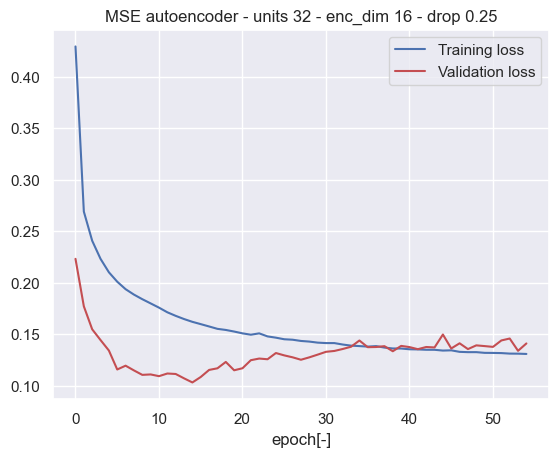

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u32_e16_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u32_e16_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u32_e16_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u32_e16_d0.25/assets


Training: units 32 - enc_dim 16 - drop 0.05 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 32)          17536     
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 dense (Dense)               (None, None, 16)          528       
                                                                 
Total params: 18,064
Trainable params: 18,064
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape            

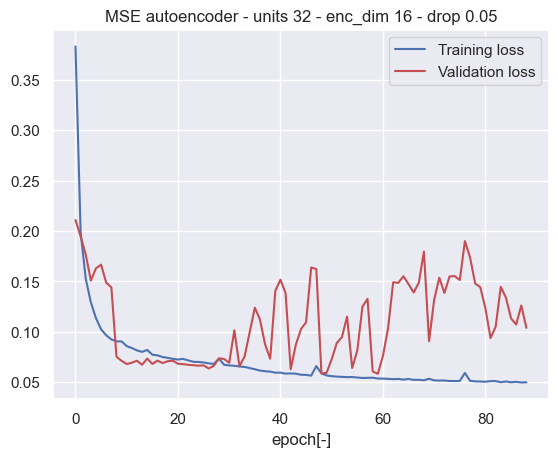

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u32_e16_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u32_e16_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u32_e16_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u32_e16_d0.05/assets


Training: units 64 - enc_dim 4 - drop 0.25 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 64)          43264     
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 dense (Dense)               (None, None, 4)           260       
                                                                 
Total params: 43,524
Trainable params: 43,524
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape             

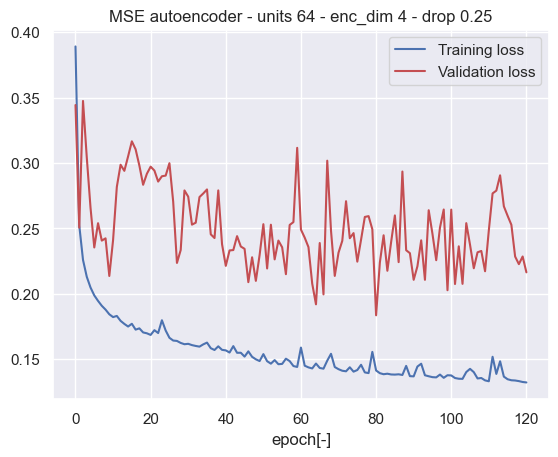

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u64_e4_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u64_e4_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u64_e4_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u64_e4_d0.25/assets


Training: units 64 - enc_dim 4 - drop 0.05 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 64)          43264     
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 dense (Dense)               (None, None, 4)           260       
                                                                 
Total params: 43,524
Trainable params: 43,524
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape             

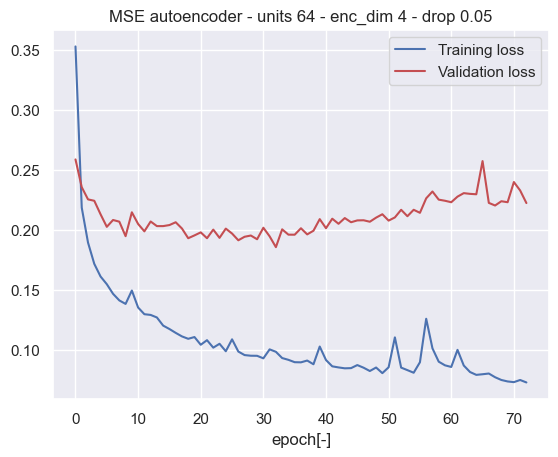

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u64_e4_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u64_e4_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u64_e4_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u64_e4_d0.05/assets


Training: units 64 - enc_dim 8 - drop 0.25 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 64)          43264     
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 dense (Dense)               (None, None, 8)           520       
                                                                 
Total params: 43,784
Trainable params: 43,784
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape             

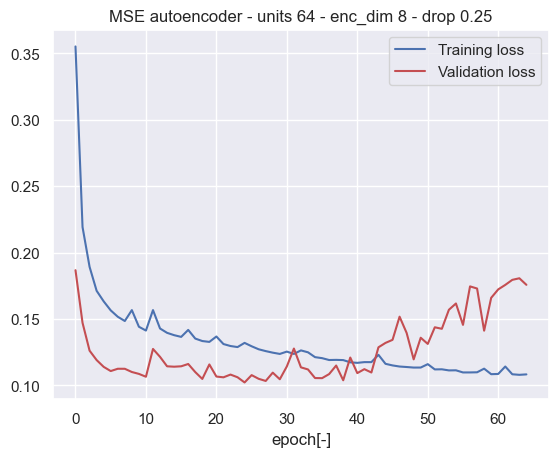

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u64_e8_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u64_e8_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u64_e8_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u64_e8_d0.25/assets


Training: units 64 - enc_dim 8 - drop 0.05 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 64)          43264     
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 dense (Dense)               (None, None, 8)           520       
                                                                 
Total params: 43,784
Trainable params: 43,784
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape             

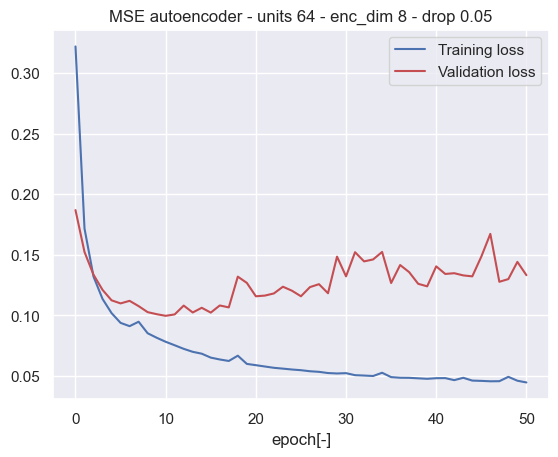

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u64_e8_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u64_e8_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u64_e8_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u64_e8_d0.05/assets


Training: units 64 - enc_dim 12 - drop 0.25 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 64)          43264     
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 dense (Dense)               (None, None, 12)          780       
                                                                 
Total params: 44,044
Trainable params: 44,044
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape            

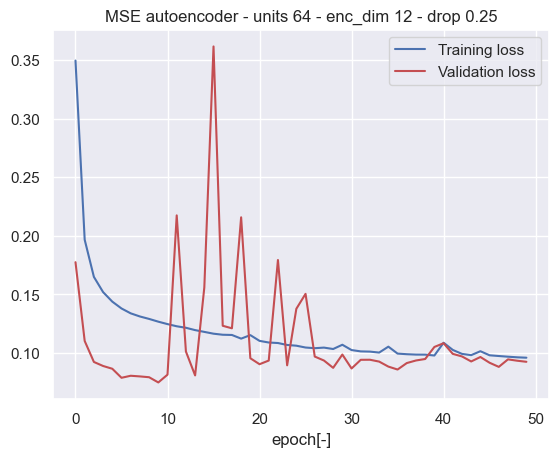

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u64_e12_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u64_e12_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u64_e12_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u64_e12_d0.25/assets


Training: units 64 - enc_dim 12 - drop 0.05 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 64)          43264     
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 dense (Dense)               (None, None, 12)          780       
                                                                 
Total params: 44,044
Trainable params: 44,044
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape            

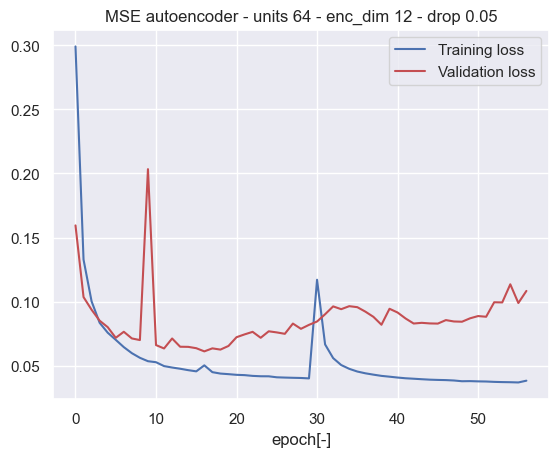

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u64_e12_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u64_e12_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u64_e12_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u64_e12_d0.05/assets


Training: units 64 - enc_dim 16 - drop 0.25 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 64)          43264     
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 dense (Dense)               (None, None, 16)          1040      
                                                                 
Total params: 44,304
Trainable params: 44,304
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape            

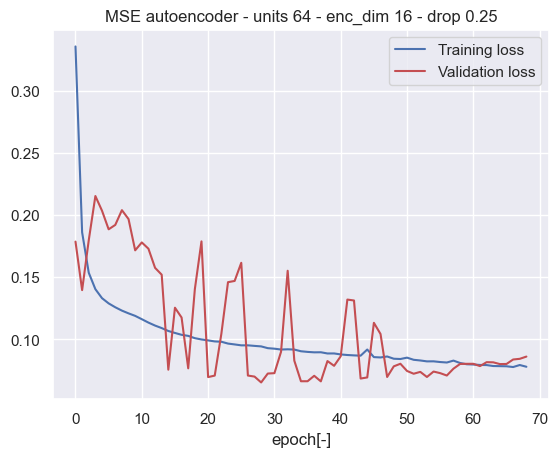

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u64_e16_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u64_e16_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u64_e16_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u64_e16_d0.25/assets


Training: units 64 - enc_dim 16 - drop 0.05 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 64)          43264     
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 dense (Dense)               (None, None, 16)          1040      
                                                                 
Total params: 44,304
Trainable params: 44,304
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape            

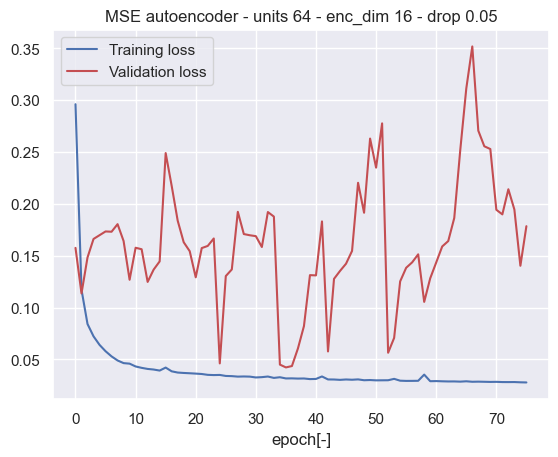

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u64_e16_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u64_e16_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u64_e16_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u64_e16_d0.05/assets


Training: units 128 - enc_dim 4 - drop 0.25 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 128)         119296    
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 dense (Dense)               (None, None, 4)           516       
                                                                 
Total params: 119,812
Trainable params: 119,812
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape          

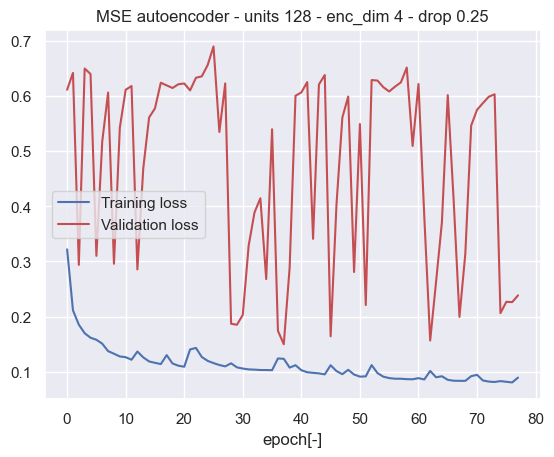

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u128_e4_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u128_e4_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u128_e4_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u128_e4_d0.25/assets


Training: units 128 - enc_dim 4 - drop 0.05 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 128)         119296    
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 dense (Dense)               (None, None, 4)           516       
                                                                 
Total params: 119,812
Trainable params: 119,812
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape          

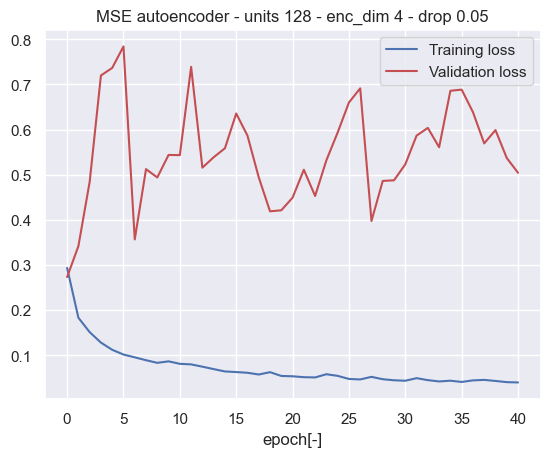

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u128_e4_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u128_e4_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u128_e4_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u128_e4_d0.05/assets


Training: units 128 - enc_dim 8 - drop 0.25 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 128)         119296    
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 dense (Dense)               (None, None, 8)           1032      
                                                                 
Total params: 120,328
Trainable params: 120,328
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape          

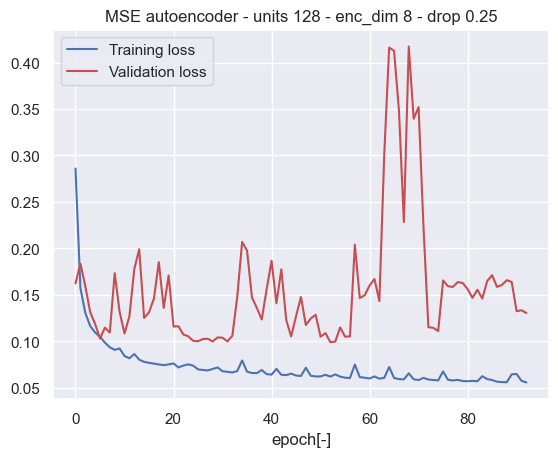

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u128_e8_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u128_e8_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u128_e8_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u128_e8_d0.25/assets


Training: units 128 - enc_dim 8 - drop 0.05 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 128)         119296    
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 dense (Dense)               (None, None, 8)           1032      
                                                                 
Total params: 120,328
Trainable params: 120,328
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape          

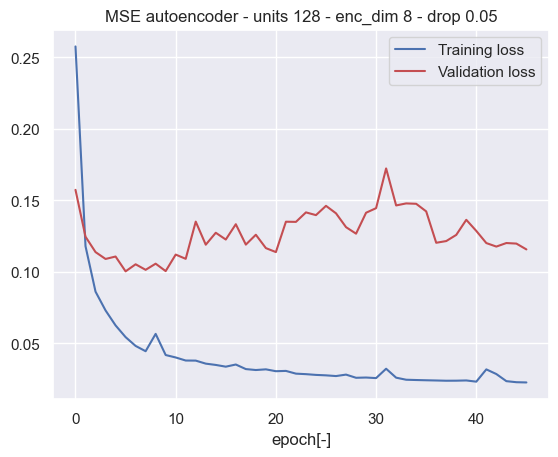

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u128_e8_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u128_e8_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u128_e8_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u128_e8_d0.05/assets


Training: units 128 - enc_dim 12 - drop 0.25 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 128)         119296    
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 dense (Dense)               (None, None, 12)          1548      
                                                                 
Total params: 120,844
Trainable params: 120,844
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape         

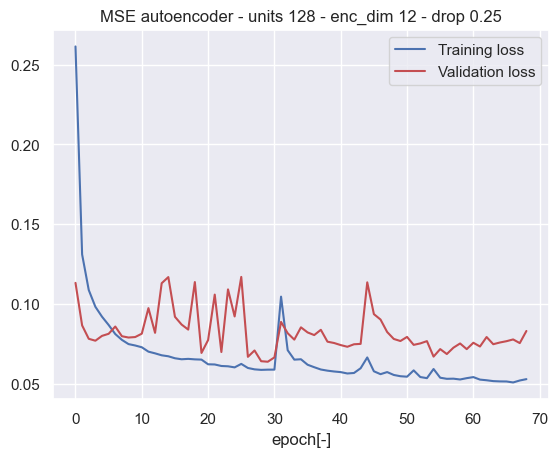

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u128_e12_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u128_e12_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u128_e12_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u128_e12_d0.25/assets


Training: units 128 - enc_dim 12 - drop 0.05 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 128)         119296    
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 dense (Dense)               (None, None, 12)          1548      
                                                                 
Total params: 120,844
Trainable params: 120,844
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape         

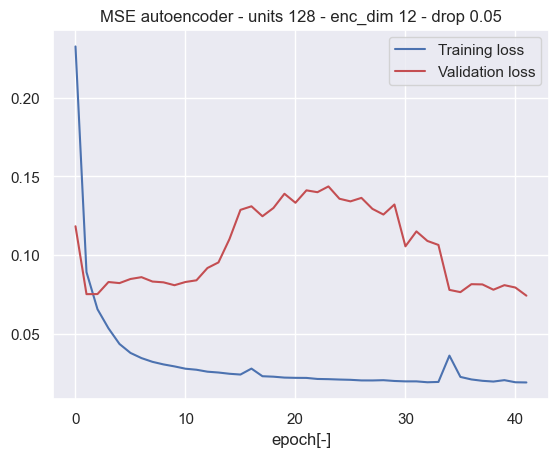

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u128_e12_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u128_e12_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u128_e12_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u128_e12_d0.05/assets


Training: units 128 - enc_dim 16 - drop 0.25 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 128)         119296    
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 dense (Dense)               (None, None, 16)          2064      
                                                                 
Total params: 121,360
Trainable params: 121,360
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape         

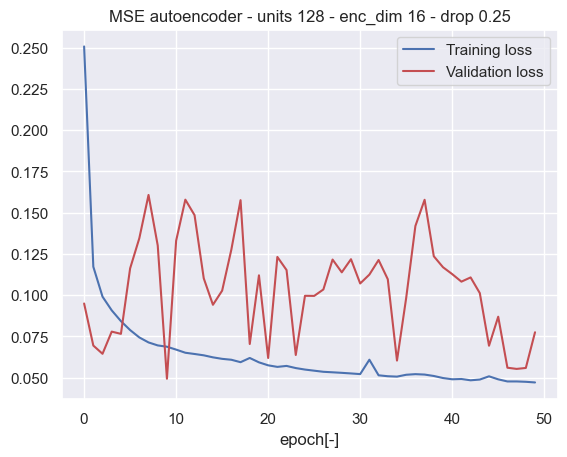

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u128_e16_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u128_e16_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u128_e16_d0.25/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u128_e16_d0.25/assets


Training: units 128 - enc_dim 16 - drop 0.05 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 128)         119296    
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 dense (Dense)               (None, None, 16)          2064      
                                                                 
Total params: 121,360
Trainable params: 121,360
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape         

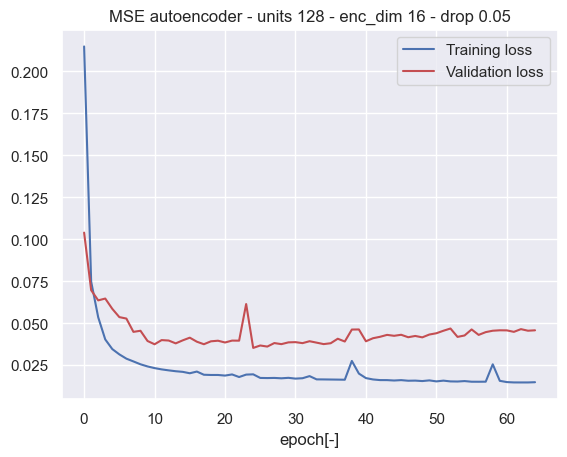

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u128_e16_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u128_e16_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u128_e16_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u128_e16_d0.05/assets


In [60]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5
epochs = 150 #6 #300
patience = 40 #3 #100
for n_unit_enc in [16, 32, 64, 128]:
    for encoding_dim in [4, 8, 12, 16]:
        for dropout_autoenc in [0.25, 0.05]:
            # check already done ? 
            #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
            path_jpg = os.path.join(path_data, 
                f"output_MSE autoencoder - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}.jpg")
            if os.path.exists(path_jpg):
                continue
            print(f"Training: units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc} ...")
            # Init
            tf.keras.backend.clear_session()
            tf.random.set_seed(0)
            # Input dimension
            input_dim = X_train.shape[-1]
            # Reduced encoded input dimension
            # 64/8/0.5
            # Définir l'encodeur
            encoder_inputs = keras.Input(shape=(None, input_dim))
            encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
            #encoder = layers.LSTM(64, return_sequences=True)(encoder)
            #encoder = layers.LSTM(16, return_sequences=True)(encoder)
            encoder = layers.Dropout(dropout_autoenc)(encoder)
            encoder_outputs = layers.Dense(encoding_dim)(encoder)
            encoder_model = keras.Model(encoder_inputs, encoder_outputs)
            print(encoder_model.summary())
            # Définir le décodeur
            decoder_inputs = keras.Input(shape=(None, encoding_dim))
            #decoder = layers.LSTM(16, return_sequences=True)(decoder_inputs)
            #decoder = layers.LSTM(64, return_sequences=True)(decoder)
            decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
            decoder = layers.Dropout(dropout_autoenc)(decoder)
            decoder_outputs = layers.Dense(input_dim)(decoder)
            decoder_model = keras.Model(decoder_inputs, decoder_outputs)
            print(decoder_model.summary())
            # Define complete autoencoder 
            autoencoder_inputs = keras.Input(shape=(None, input_dim))
            encoded = encoder_model(autoencoder_inputs)
            decoded = decoder_model(encoded)
            autoencoder = keras.Model(autoencoder_inputs, decoded)
            # Compile : autoencoder
            autoencoder.compile(optimizer="adam", loss="mse")
            # earlystop 
            es = EarlyStopping(patience=patience, verbose=2, min_delta=0.001, 
                            monitor='val_loss', mode='auto', restore_best_weights=True)
            # Train
            autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                verbose=1, callbacks=[es])

            plot_train_history(
                autoenc_step_history,f"MSE autoencoder - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}",
                saveFolder="data")
            autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
            encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")


### Save model

In [61]:
autoencoder.save(path_mdl_autoencoder)
encoder_model.save(path_mdl_encoder)


INFO:tensorflow:Assets written to: data/mdl_autoencoder/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder/assets


INFO:tensorflow:Assets written to: data/mdl_encoder/assets


INFO:tensorflow:Assets written to: data/mdl_encoder/assets


In [62]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

472/472 [==============================] - 11s 20ms/step


(15080, 48, 104)

### Results

In [85]:
encoder_model = tf.keras.models.load_model(os.path.join(path_data, "mdl_encoder_u128_e16_d0.05"))

In [86]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

472/472 [==============================] - 6s 12ms/step


(15080, 48, 16)

In [89]:
X_train_encoded[:, -1, :].shape

(15080, 16)

In [95]:
y_train.shape

(15080, 13)

In [97]:
X_train[:,-1,:nb_plot].shape

(15080, 104)

In [100]:
np.hstack((X_train[:,-1,:nb_plot], y_train)).shape

(15080, 117)

In [103]:
3 * ["R"]

['R', 'R', 'R']

In [106]:
pd.DataFrame(X_train[:,0,:nb_plot], columns=list_col_select[:nb_plot])

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0       0.955002  0.965190  0.967996  0.954308          0.992102   
1       0.958774  0.945855  0.959142  0.941181          0.982600   
2       0.945897  0.967721  0.969308  0.944402          0.991621   
3       0.953553  0.950361  0.957732  0.947880          0.996795   
4       0.924524  0.948642  0.949226  0.921244          0.993003   
...          ...       ...       ...       ...               ...   
15075   0.988420  0.988349  0.991169  0.987924          0.967244   
15076   0.994589  0.991610  0.998823  0.989284          0.969166   
15077   0.993842  0.992959  0.993892  0.990658          0.967583   
15078   0.999529  0.998160  1.001751  0.997988          0.971359   
15079   0.992588  0.995458  0.995750  0.991340          0.966958   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0              0.985997        0.987242         0.955612   
1              0.976554        0.977786         0.946459   
2              0.985519        0.985406         0.955149   
3              0.990118        0.988129         0.959606   
4              0.985024        0.973492         0.945259   
...                 ...             ...              ...   
15075          0.981523        0.978397         0.986049   
15076          0.984691        0.981554         0.990745   
15077          0.983083        0.979951         0.989127   
15078          0.987354        0.984209         0.993538   
15079          0.983332        0.980200         0.989492   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_sin  weekday_cos  \
0                  1.266508              1.383137  ... -0.258819    -0.900969   
1                  1.254377              1.369889  ...  0.000000    -0.900969   
2                  1.265893              1.382466  ...  0.258819    -0.900969   
3                  1.271801              1.388918  ...  0.500000    -0.900969   
4                  1.265257              1.381771  ...  0.707107    -0.900969   
...                     ...                   ...  ...       ...          ...   
15075              0.894009              0.811995  ...  0.500000    -0.222521   
15076              0.897043              0.814616  ...  0.707107    -0.222521   
15077              0.895578              0.813286  ...  0.866025    -0.222521   
15078              0.899469              0.816819  ...  0.965926    -0.222521   
15079              0.895806              0.813492  ...  1.000000    -0.222521   

       weekday_sin  day_in_month_cos  day_in_month_sin     month_cos  \
0         0.433884          0.979530          0.201299 -8.660254e-01   
1        -0.433884          0.918958          0.394356 -8.660254e-01   
2        -0.433884          0.918958          0.394356 -8.660254e-01   
3        -0.433884          0.918958          0.394356 -8.660254e-01   
4        -0.433884          0.918958          0.394356 -8.660254e-01   
...            ...               ...               ...           ...   
15075     0.974928         -0.250653         -0.968077  6.123234e-17   
15076     0.974928         -0.250653         -0.968077  6.123234e-17   
15077     0.974928         -0.250653         -0.968077  6.123234e-17   
15078     0.974928         -0.250653         -0.968077  6.123234e-17   
15079     0.974928         -0.250653         -0.968077  6.123234e-17   

       month_sin  day_off  event_pred  event_real  
0           -0.5      0.0         0.0         0.0  
1           -0.5      0.0         0.0         0.0  
2           -0.5      0.0         0.0         0.0  
3           -0.5      0.0         0.0         0.0  
4           -0.5      0.0         0.0         0.0  
...          ...      ...         ...         ...  
15075        1.0      0.0         0.0         0.0  
15076        1.0      0.0         0.0         0.0  
15077        1.0      0.0         0.0         0.0  
15078        1.0      0.0         0.0         0.0  
15079        1.0      0.0         0.0         0.0  

[15080

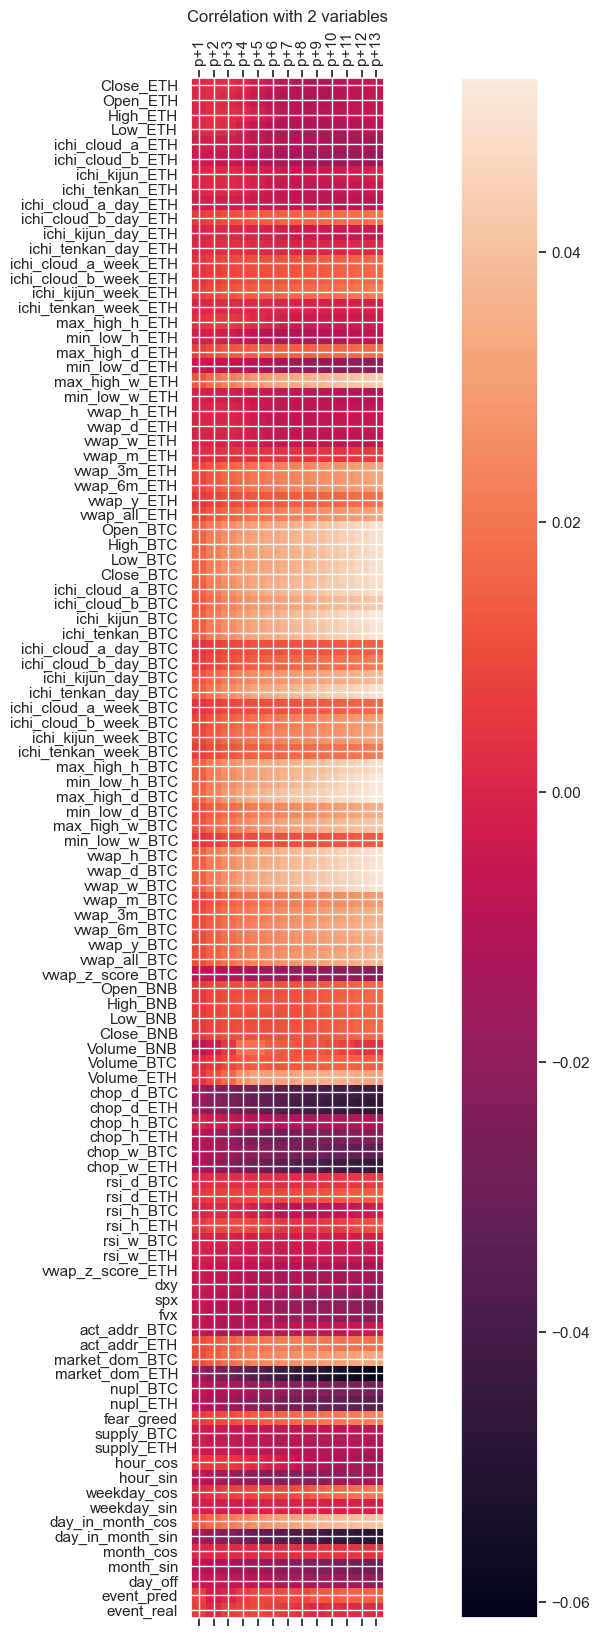

In [129]:
nb_plot = 104
list_targets = [f"p+{t}" for t in range(1, FUTURE_TARGET+1)]
# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
df = pd.DataFrame(np.hstack((X_train[:,6,:nb_plot], y_train)), 
    columns=list_col_select[:nb_plot] + list_targets)
#df = pd.DataFrame(X_train[:,0,:nb_plot], columns=list_col_select[:nb_plot])
#df_compare = pd.DataFrame(y_train, columns=[f"p+{t}" for t in range(1, FUTURE_TARGET+1)])
# Calculer la matrice de corrélation
corr_matrix = df.corr()
corr_matrix = corr_matrix[list_targets].iloc[:-FUTURE_TARGET]
# Afficher la matrice de corrélation
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.matshow(corr_matrix)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.title('Corrélation with 2 variables')
fig.colorbar(im)
plt.show()

In [125]:
corr_matrix[list_targets].iloc[:-FUTURE_TARGET]

p+1       p+2       p+3       p+4       p+5       p+6  \
Close_ETH              NaN       NaN       NaN       NaN       NaN       NaN   
Open_ETH         -0.008935  0.000159  0.006343  0.008746  0.012216  0.004721   
High_ETH          0.008075  0.010246  0.013456  0.013058  0.019095  0.009170   
Low_ETH          -0.016194 -0.013906 -0.010495 -0.006580 -0.003545 -0.002979   
ichi_cloud_a_ETH  0.004603  0.007871  0.009260  0.009024  0.008067  0.006454   
...                    ...       ...       ...       ...       ...       ...   
month_cos         0.001615  0.002248  0.002754  0.003243  0.003722  0.004184   
month_sin        -0.007130 -0.010008 -0.012373 -0.014512 -0.016309 -0.017900   
day_off           0.007488  0.009276  0.009893  0.009024  0.008447  0.006781   
event_pred        0.000312  0.006284 -0.003869 -0.002292 -0.002348  0.007928   
event_real       -0.026873 -0.031320 -0.030873 -0.027064 -0.030265 -0.025486   

                       p+7       p+8       p+9      p+10      p+11      p+12  \
Close_ETH              NaN       NaN       NaN       NaN       NaN       NaN   
Open_ETH          0.007247  0.000186  0.000184  0.001950 -0.000574  0.000086   
High_ETH          0.013252  0.011836  0.014637  0.016310  0.017425  0.020984   
Low_ETH          -0.001234 -0.006052 -0.008437 -0.004821 -0.007445 -0.008763   
ichi_cloud_a_ETH  0.006009  0.005322  0.006201  0.006598  0.006391  0.006834   
...                    ...       ...       ...       ...       ...       ...   
month_cos         0.004626  0.005096  0.005554  0.005917  0.006246  0.006489   
month_sin        -0.019391 -0.020836 -0.022163 -0.023390 -0.024608 -0.025792   
day_off           0.006687  0.006673  0.005809  0.003777  0.001798 -0.000851   
event_pred        0.008397 -0.000685  0.000727 -0.003416 -0.001019  0.002006   
event_real       -0.015902 -0.010814 -0.010424 -0.008294 -0.006855 -0.007692   

                      p+13  
Close_ETH              NaN  
Open_ETH          0.000705  
High_ETH          0.022836  
Low_ETH          -0.009702  
ichi_cloud_a_ETH  0.007059  
...                    ...  
month_cos         0.006752  
month_sin        -0.026885  
day_off          -0.003387  
event_pred       -0.000388  
event_real       -0.007205  

[104 rows x 13 columns]

In [120]:
corr_matrix

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
Close_ETH               NaN       NaN       NaN       NaN               NaN   
Open_ETH                NaN  1.000000  0.649981  0.576334          0.183201   
High_ETH                NaN  0.649981  1.000000 -0.009761          0.243966   
Low_ETH                 NaN  0.576334 -0.009761  1.000000         -0.066516   
ichi_cloud_a_ETH        NaN  0.183201  0.243966 -0.066516          1.000000   
...                     ...       ...       ...       ...               ...   
p+9                     NaN  0.000184  0.014637 -0.008437          0.006201   
p+10                    NaN  0.001950  0.016310 -0.004821          0.006598   
p+11                    NaN -0.000574  0.017425 -0.007445          0.006391   
p+12                    NaN  0.000086  0.020984 -0.008763          0.006834   
p+13                    NaN  0.000705  0.022836 -0.009702          0.007059   

                  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
Close_ETH                      NaN             NaN              NaN   
Open_ETH                  0.159239        0.326732         0.503604   
High_ETH                  0.254308        0.293438         0.370095   
Low_ETH                  -0.087778        0.051063         0.201320   
ichi_cloud_a_ETH          0.915868        0.811980         0.434273   
...                            ...             ...              ...   
p+9                       0.002225       -0.001754         0.006529   
p+10                      0.002328       -0.000093         0.007226   
p+11                      0.002048        0.001080         0.007274   
p+12                      0.002423        0.002477         0.008681   
p+13                      0.002694        0.004114         0.008761   

                  ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...       p+4  \
Close_ETH                          NaN                   NaN  ...       NaN   
Open_ETH                      0.040950              0.028298  ...  0.008746   
High_ETH                      0.192627              0.194912  ...  0.013058   
Low_ETH                      -0.110204             -0.122055  ... -0.006580   
ichi_cloud_a_ETH              0.243745              0.178231  ...  0.009024   
...                                ...                   ...  ...       ...   
p+9                          -0.005295              0.015766  ...  0.663850   
p+10                         -0.005799              0.016398  ...  0.633461   
p+11                         -0.006248              0.017052  ...  0.604912   
p+12                         -0.006506              0.017848  ...  0.582193   
p+13                         -0.006508              0.018907  ...  0.559477   

                       p+5       p+6       p+7       p+8       p+9      p+10  \
Close_ETH              NaN       NaN       NaN       NaN       NaN       NaN   
Open_ETH          0.012216  0.004721  0.007247  0.000186  0.000184  0.001950   
High_ETH          0.019095  0.009170  0.013252  0.011836  0.014637  0.016310   
Low_ETH          -0.003545 -0.002979 -0.001234 -0.006052 -0.008437 -0.004821   
ichi_cloud_a_ETH  0.008067  0.006454  0.006009  0.005322  0.006201  0.006598   
...                    ...       ...       ...       ...       ...       ...   
p+9               0.741620  0.812657  0.879319  0.942164  1.000000  0.948275   
p+10              0.705944  0.772253  0.833898  0.892425  0.948275  1.000000   
p+11              0.675781  0.737997  0.795886  0.850384  0.902745  0.953059   
p+12              0.648465  0.709488  0.763901  0.815271  0.864167  0.911421   
p+13              0.625460  0.682806  0.736423  0.784933  0.831199  0.875506   

                      p+11      p+12      p+13  
Close_ETH              NaN       NaN       NaN  
Open_ETH         -0.000574  0.000086  0.000705  
High_ETH          0.017425  0.020984  0.022836  
Low_ETH          -0.007445 -0.008763 -0.009702  
ichi_cloud_a_ETH  0.006391  0.006834  0.007059  
...         

In [83]:
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0            1.0  0.993784  1.001959  0.991594          0.942887   
1            1.0  0.990516  1.002829  0.983624          0.935645   
2            1.0  1.009181  1.011030  0.999275          0.951383   
3            1.0  1.004667  1.006287  0.996859          0.958419   
4            1.0  0.994850  1.003669  0.993052          0.954846   
...          ...       ...       ...       ...               ...   
15075        1.0  0.997334  1.001713  0.995202          0.972361   
15076        1.0  1.003233  1.005013  0.999691          0.974249   
15077        1.0  0.998361  1.000673  0.998168          0.972658   
15078        1.0  1.004350  1.005979  0.999235          0.976884   
15079        1.0  0.995927  1.000960  0.995739          0.967572   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0              0.976189        0.981139         1.003582   
1              0.966839        0.975195         0.993458   
2              0.975715        0.986077         1.002578   
3              0.980268        0.990678         1.007257   
4              0.975225        0.985581         1.001071   
...                 ...             ...              ...   
15075          0.976499        0.987900         0.998452   
15076          0.979650        0.991088         1.000978   
15077          0.978050        0.989469         0.997953   
15078          0.982300        0.993996         1.004062   
15079          0.978299        0.989947         0.999972   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH    target  
0                  1.251115              1.383137  1.009671  
1                  1.231988              1.369889  0.990903  
2                  1.244704              1.382466  0.995355  
3                  1.252753              1.388918  1.005172  
4                  1.252251              1.381771  1.000856  
...                     ...                   ...       ...  
15075              0.893669              0.820553  0.996783  
15076              0.896553              0.823202  1.001636  
15077              0.895089              0.821857  0.995674  
15078              0.898978              0.825428  1.004090  
15079              0.895316              0.822066  1.000762  

[15080 rows x 11 columns]

In [82]:
corr_matrix

Close_ETH  Open_ETH  High_ETH   Low_ETH  \
Close_ETH                   NaN       NaN       NaN       NaN   
Open_ETH                    NaN  1.000000  0.649981  0.576334   
High_ETH                    NaN  0.649981  1.000000 -0.009761   
Low_ETH                     NaN  0.576334 -0.009761  1.000000   
ichi_cloud_a_ETH            NaN  0.183201  0.243966 -0.066516   
ichi_cloud_b_ETH            NaN  0.159239  0.254308 -0.087778   
ichi_kijun_ETH              NaN  0.326732  0.293438  0.051063   
ichi_tenkan_ETH             NaN  0.503604  0.370095  0.201320   
ichi_cloud_a_day_ETH        NaN  0.040950  0.192627 -0.110204   
ichi_cloud_b_day_ETH        NaN  0.028298  0.194912 -0.122055   
target                      NaN -0.008935  0.008075 -0.016194   

                      ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  \
Close_ETH                          NaN               NaN             NaN   
Open_ETH                      0.183201          0.159239        0.326732   
High_ETH                      0.243966          0.254308        0.293438   
Low_ETH                      -0.066516         -0.087778        0.051063   
ichi_cloud_a_ETH              1.000000          0.915868        0.811980   
ichi_cloud_b_ETH              0.915868          1.000000        0.684398   
ichi_kijun_ETH                0.811980          0.684398        1.000000   
ichi_tenkan_ETH               0.434273          0.365425        0.703489   
ichi_cloud_a_day_ETH          0.243745          0.312550        0.173538   
ichi_cloud_b_day_ETH          0.178231          0.233593        0.139718   
target                        0.004603          0.003393       -0.002553   

                      ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
Close_ETH                         NaN                   NaN   
Open_ETH                     0.503604              0.040950   
High_ETH                     0.370095              0.192627   
Low_ETH                      0.201320             -0.110204   
ichi_cloud_a_ETH             0.434273              0.243745   
ichi_cloud_b_ETH             0.365425              0.312550   
ichi_kijun_ETH               0.703489              0.173538   
ichi_tenkan_ETH              1.000000              0.109930   
ichi_cloud_a_day_ETH         0.109930              1.000000   
ichi_cloud_b_day_ETH         0.093736              0.906712   
target                       0.005845             -0.000889   

                      ichi_cloud_b_day_ETH    target  
Close_ETH                              NaN       NaN  
Open_ETH                          0.028298 -0.008935  
High_ETH                          0.194912  0.008075  
Low_ETH                          -0.122055 -0.016194  
ichi_cloud_a_ETH                  0.178231  0.004603  
ichi_cloud_b_ETH                  0.233593  0.003393  
ichi_kijun_ETH                    0.139718 -0.002553  
ichi_tenkan_ETH                   0.093736  0.005845  
ichi_cloud_a_day_ETH              0.906712 -0.000889  
ichi_cloud_b_day_ETH              1.000000  0.005822  
target                            0.005822  1.000000

In [ ]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

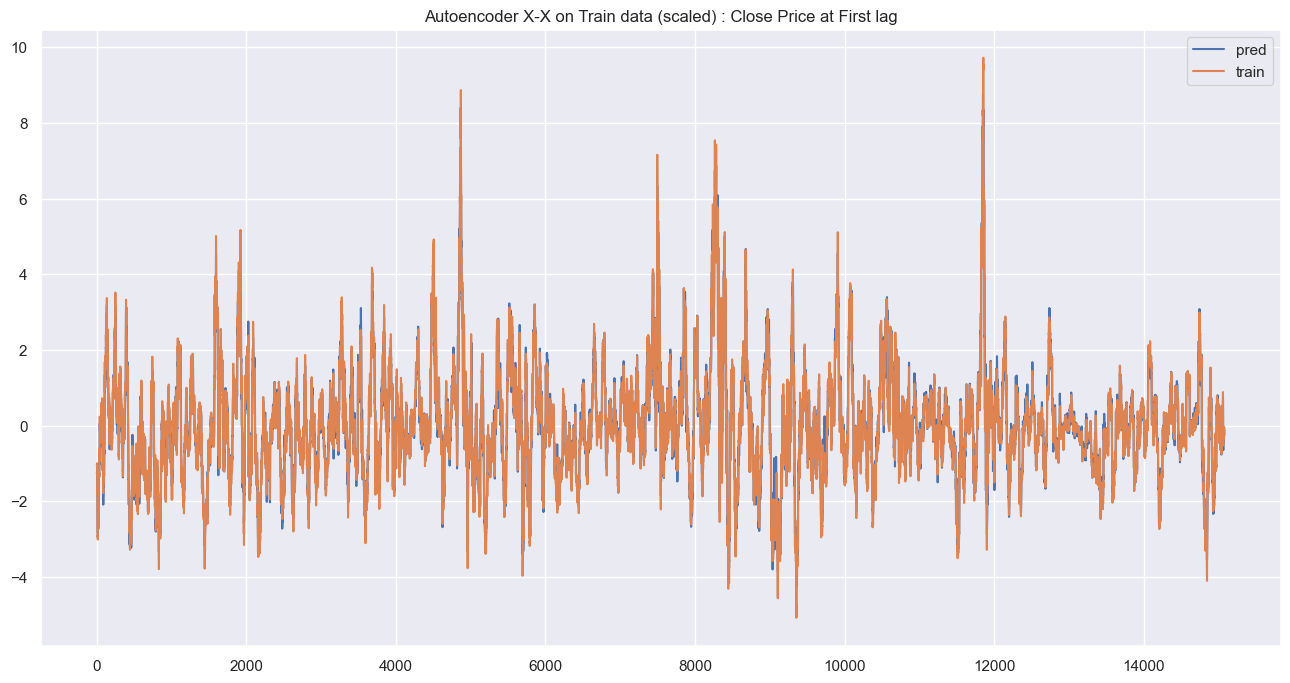

In [63]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

In [64]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(15080,)
(15080,)
[2106.41 2135.18 2087.34 ... 1801.18 1803.65 1798.45]
[2106.41 2135.18 2087.34]


In [65]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([0.994751 , 0.9958239, 1.0066504, ..., 1.0022559, 1.0095263,
       1.0022246], dtype=float32)

[2106.41 2135.18 2087.34 ... 1801.18 1803.65 1798.45]
[2093.86233571 2106.65298477 2102.66304739 ... 1795.23020537 1799.50582525
 1791.85000386]


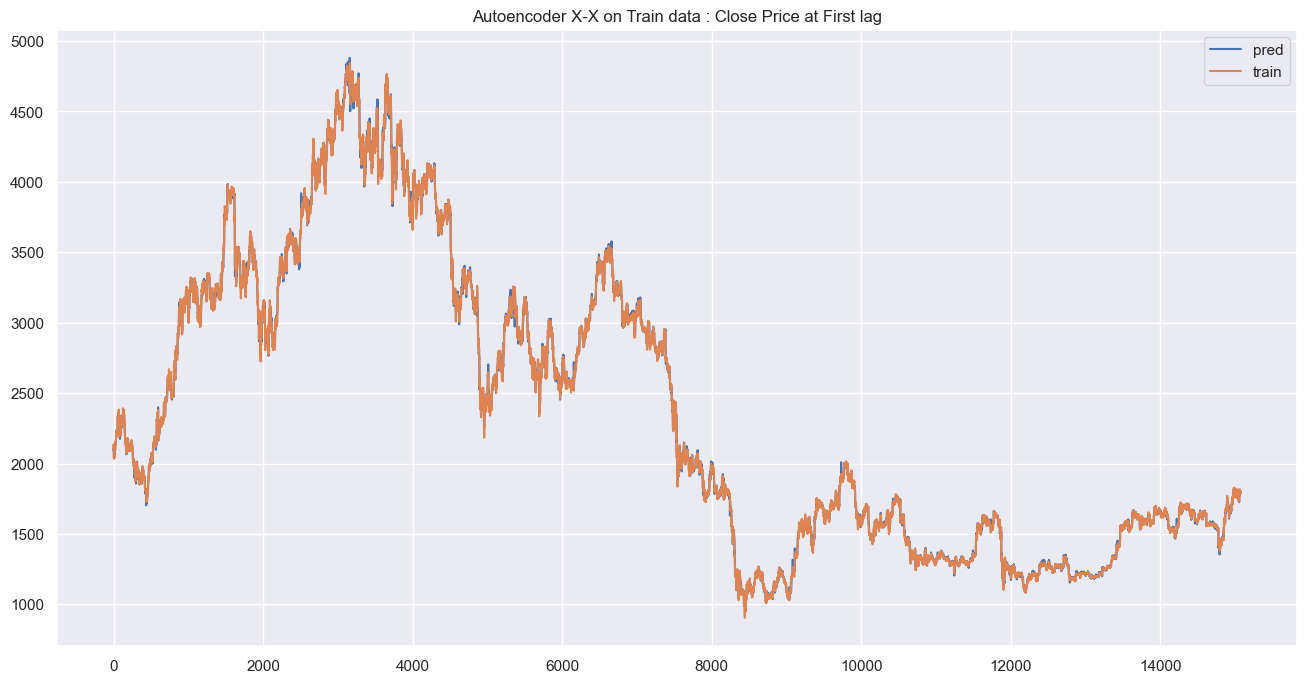

In [66]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### on Test data

In [67]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

3/3 [==============================] - 0s 156ms/step


(91, 48, 104)

In [68]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-03-24 19:00:00'

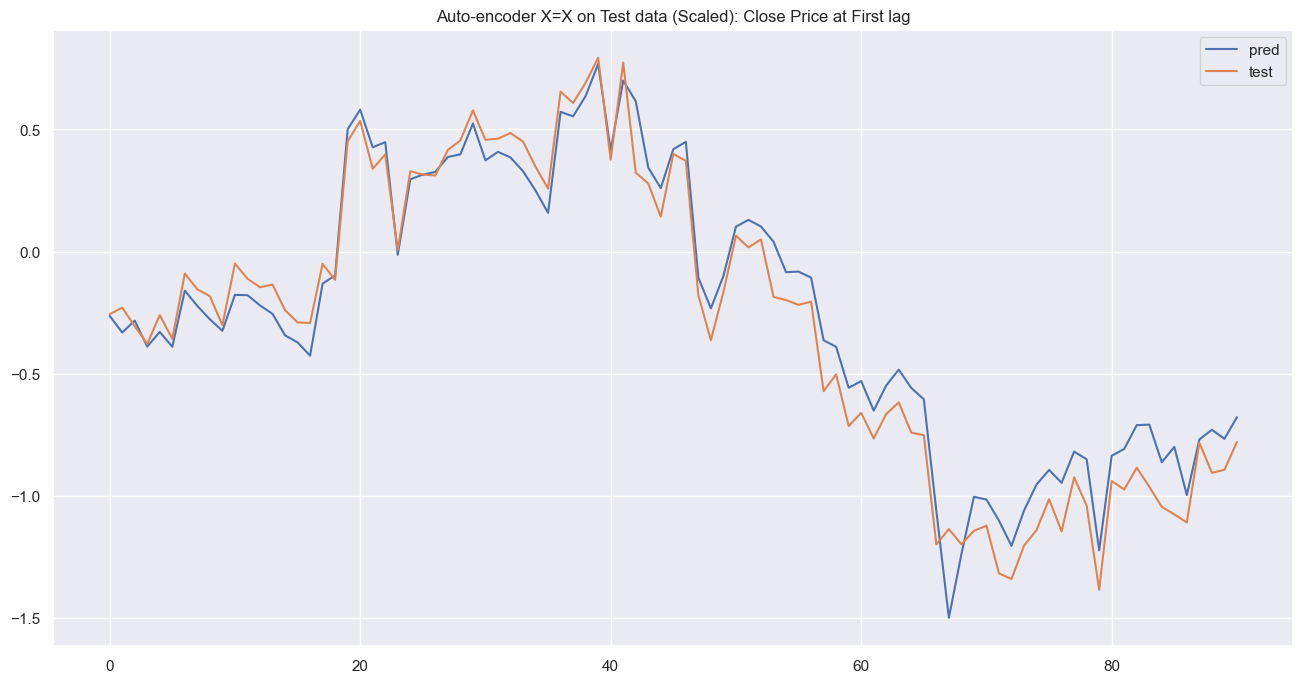

In [69]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [70]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [1748.62 1745.21 1743.26 1749.57 1756.33 1753.88 1758.66 1756.   1753.37]
X test pred :  [1748.10571802 1737.57203369 1744.96108539 1748.73240416 1751.11188726
 1751.41752361 1753.38547875 1750.87735252 1746.22877181]


[1748.62 1745.21 1743.26 1749.57 1756.33 1753.88 1758.66 1756.   1753.37
 1744.05 1748.74 1747.25 1743.38 1748.17 1747.45 1745.25 1745.5  1754.42
 1748.32 1754.93 1752.84 1744.32 1738.93 1716.98 1730.55 1732.76 1737.83
 1741.88 1750.58 1751.7  1752.59 1749.57 1749.12 1753.24 1751.91 1752.55
 1774.75 1774.99 1771.43 1777.76 1775.57 1796.47 1763.63 1762.81 1756.8
 1766.97 1765.99 1765.82 1760.35 1764.12 1776.08 1773.88 1778.87 1763.31
 1765.53 1765.   1764.63 1750.3  1753.44 1752.2  1756.2  1763.38 1764.96
 1765.42 1756.1  1754.93 1719.75 1711.74 1717.42 1707.92 1714.52 1704.58
 1707.74 1713.01 1709.49 1715.22 1707.56 1717.02 1713.72 1711.65 1718.16
 1724.3  1731.44 1724.53 1728.07 1718.7  1717.58 1745.48 1737.05 1737.6
 1740.03]
[1748.10571802 1737.57203369 1744.96108539 1748.73240416 1751.11188726
 1751.41752361 1753.38547875 1750.87735252 1746.22877181 1742.32328981
 1739.15151395 1742.18696265 1737.82560709 1739.19961249 1739.70379876
 1739.09031378 1735.41803253 1748.37313387 1749.7

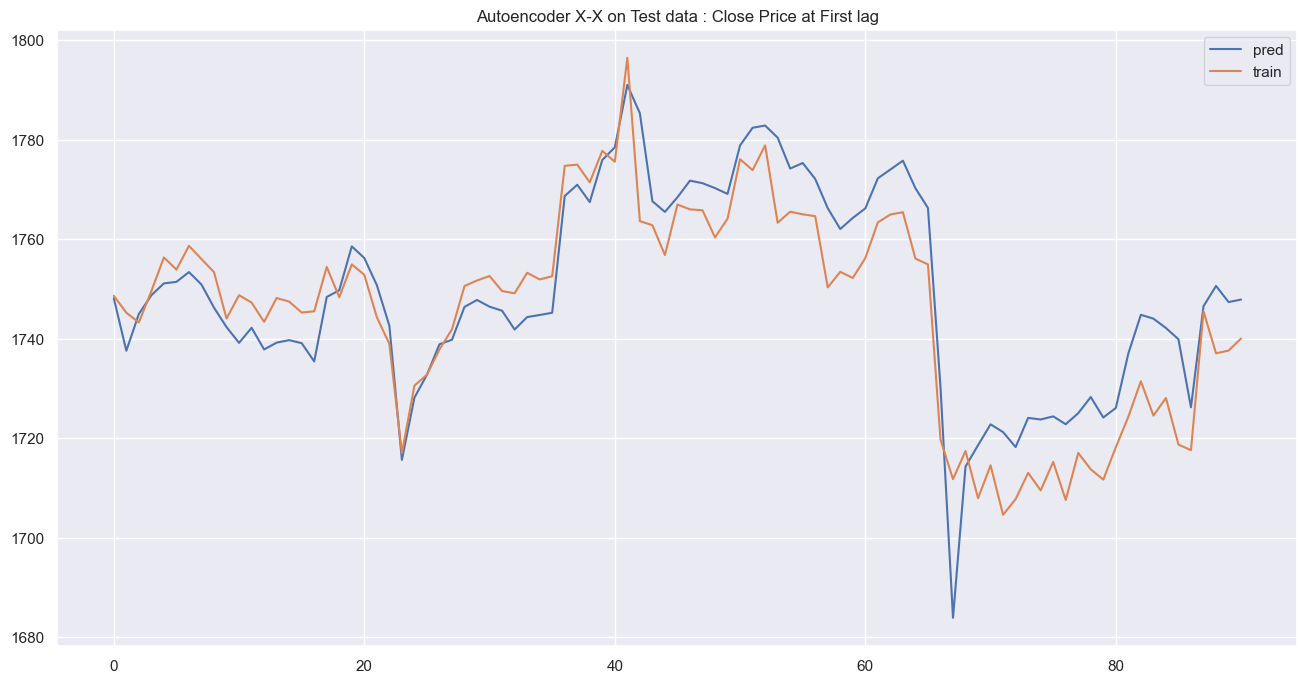

In [71]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [72]:
encoder_model.layers[3].get_weights()

[array([[ 0.26060024,  0.03315621,  0.12635325, ...,  0.29266983,
          0.34192765,  0.22451288],
        [ 0.30594888, -0.18778719, -0.08646131, ..., -0.10336554,
          0.07290308,  0.07033471],
        [ 0.06176488,  0.33161125, -0.43455863, ..., -0.14165254,
         -0.1343563 ,  0.35091662],
        ...,
        [-0.41053593, -0.10848563,  0.42922023, ...,  0.04723731,
         -0.28563198, -0.12772341],
        [ 0.24077632, -0.48022994,  0.22678746, ..., -0.07612137,
          0.06120165, -0.28362152],
        [ 0.20805654,  0.10009719,  0.0403714 , ...,  0.04819655,
          0.15174928, -0.04059589]], dtype=float32),
 array([ 0.12196203,  0.21247537,  0.0625991 , -0.02938293,  0.39892033,
         0.05164715,  0.0457686 , -0.3029281 ,  0.11952803,  0.03096539,
        -0.05966796,  0.44043204,  0.24176551,  0.1295085 ,  0.10713764,
         0.00722217], dtype=float32)]

## Prediction Models

### LSTM all features

In [ ]:
X_train_sca.shape[-1]

104

In [ ]:
X_train_sca.shape[-2:]

(48, 104)

In [ ]:
# Init
NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 100
patience = 10 
dropout_rate = 0.2
tf.keras.backend.clear_session()
tf.random.set_seed(0)

# optimizer def 
#optim = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
#                      nesterov=nesterov)
optim = tf.optimizers.Adam()

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                verbose=1, patience=patience,
                                restore_best_weights=True)
# create model
multi_step_model_1 = tf.keras.models.Sequential()
multi_step_model_1.add(tf.keras.layers.LSTM(64, 
                    return_sequences=False,
                    input_shape=X_train_sca.shape[-2:]))
multi_step_model_1.add(tf.keras.layers.Dropout(dropout_rate))
#multi_step_model.add(tf.keras.layers.BatchNormalization())
multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
# compile
multi_step_model_1.compile(optimizer=optim, loss='mse')
# fitting
'''multi_step_history = multi_step_model.fit(X_train_sca, 
                                        epochs=EPOCHS,
                                        steps_per_epoch=EVALUATION_INTERVAL,
                                        validation_data=val_data_multi,
                                        validation_steps=1,
                                        callbacks=[es],
                                        verbose=0)'''

multi_step_history_1 = multi_step_model_1.fit(
    X_train_sca, y_train_sca, epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])
# eval
mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
mse_curr_1

Epoch 1/100


2023-04-01 12:47:30.926718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-01 12:47:31.095316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  5/381 [..............................] - ETA: 5s - loss: 1.1579  

2023-04-01 12:47:31.210588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


381/381 [==============================] - ETA: 0s - loss: 0.9947

2023-04-01 12:47:37.166618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-01 12:47:37.227556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


381/381 [==============================] - 8s 18ms/step - loss: 0.9947 - val_loss: 0.5022
Epoch 2/100
381/381 [==============================] - 7s 17ms/step - loss: 0.8651 - val_loss: 0.9763
Epoch 3/100
381/381 [==============================] - 6s 17ms/step - loss: 0.7494 - val_loss: 1.3637
Epoch 4/100
381/381 [==============================] - 6s 17ms/step - loss: 0.6370 - val_loss: 1.9045
Epoch 5/100
381/381 [==============================] - 6s 17ms/step - loss: 0.5676 - val_loss: 2.3305
Epoch 6/100
381/381 [==============================] - 6s 17ms/step - loss: 0.5165 - val_loss: 2.6345
Epoch 7/100
381/381 [==============================] - 6s 17ms/step - loss: 0.4768 - val_loss: 2.9933
Epoch 8/100
381/381 [==============================] - 6s 17ms/step - loss: 0.4510 - val_loss: 2.8305
Epoch 9/100
381/381 [==============================] - 6s 17ms/step - loss: 0.4365 - val_loss: 2.6992
Epoch 10/100
381/381 [==============================] - 6s 17ms/step - loss: 0.4277 - val_loss

0.5021965503692627

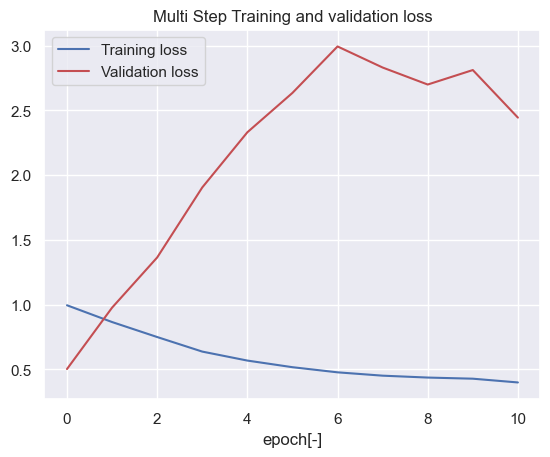

In [ ]:
plot_train_history(multi_step_history_1,
                       'Multi Step Training and validation loss')

In [ ]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]

  1/381 [..............................] - ETA: 1:51

2023-04-01 12:48:42.343448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-01 12:48:42.399664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 1s 7ms/step


In [ ]:
y_train_pred_raw_1.shape

(12174, 13)

In [ ]:
y_train_raw.shape

(12174, 13)

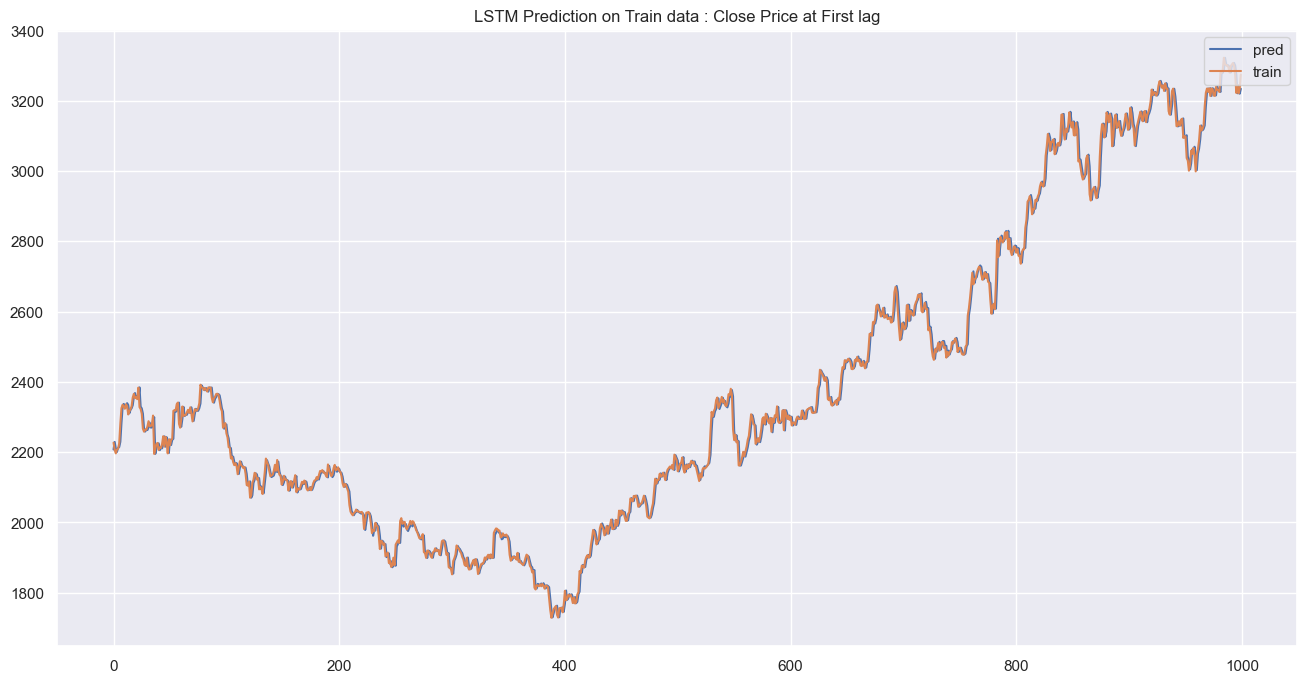

In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Train data : Close Price at First lag")
plt.plot(y_train_pred_raw_1[:1000,0], label="pred")
plt.plot(y_train_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

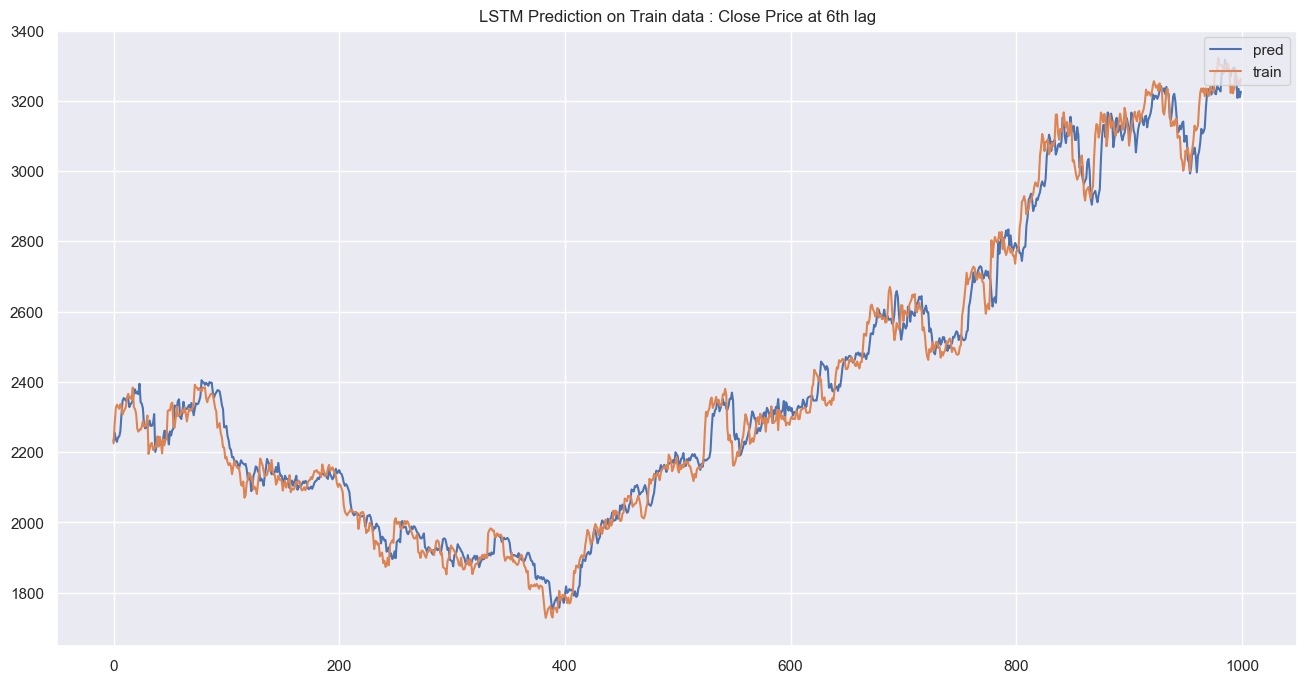

In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Train data : Close Price at 6th lag")
plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
plt.plot(y_train_raw[:1000, 5], label="train")
plt.legend(loc='upper right')

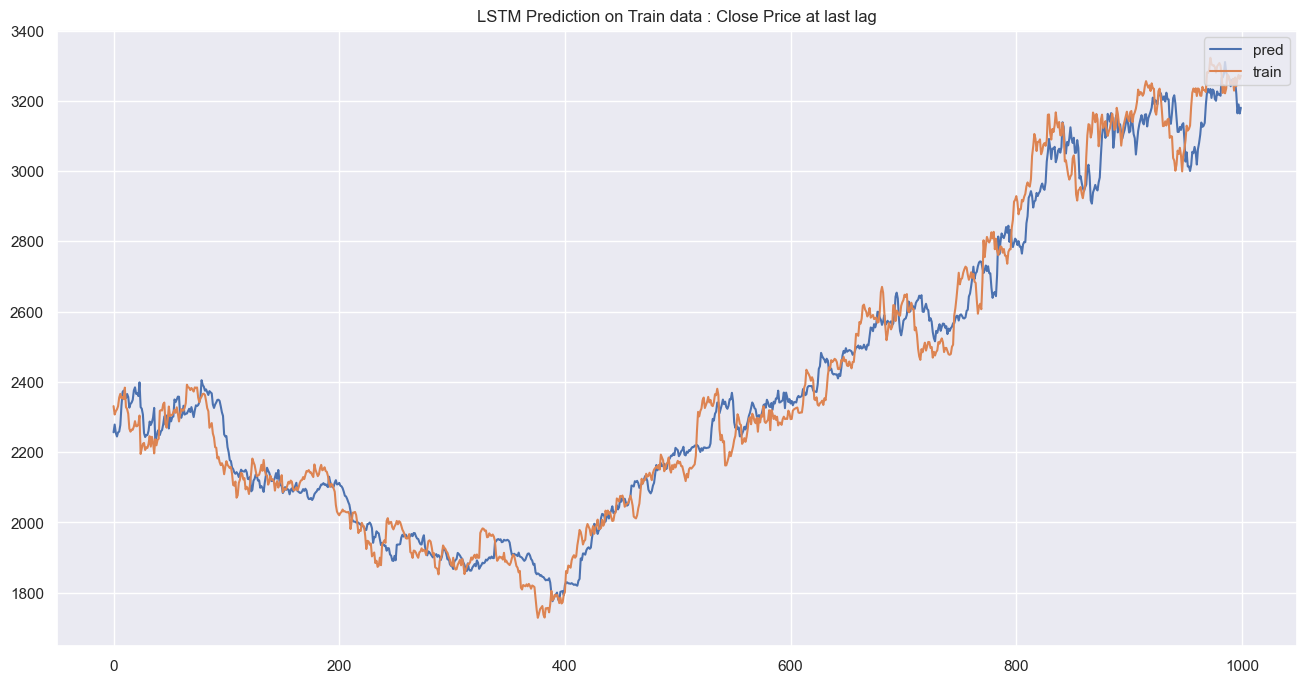

In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Train data : Close Price at last lag")
plt.plot(y_train_pred_raw_1[:1000, -1], label="pred")
plt.plot(y_train_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

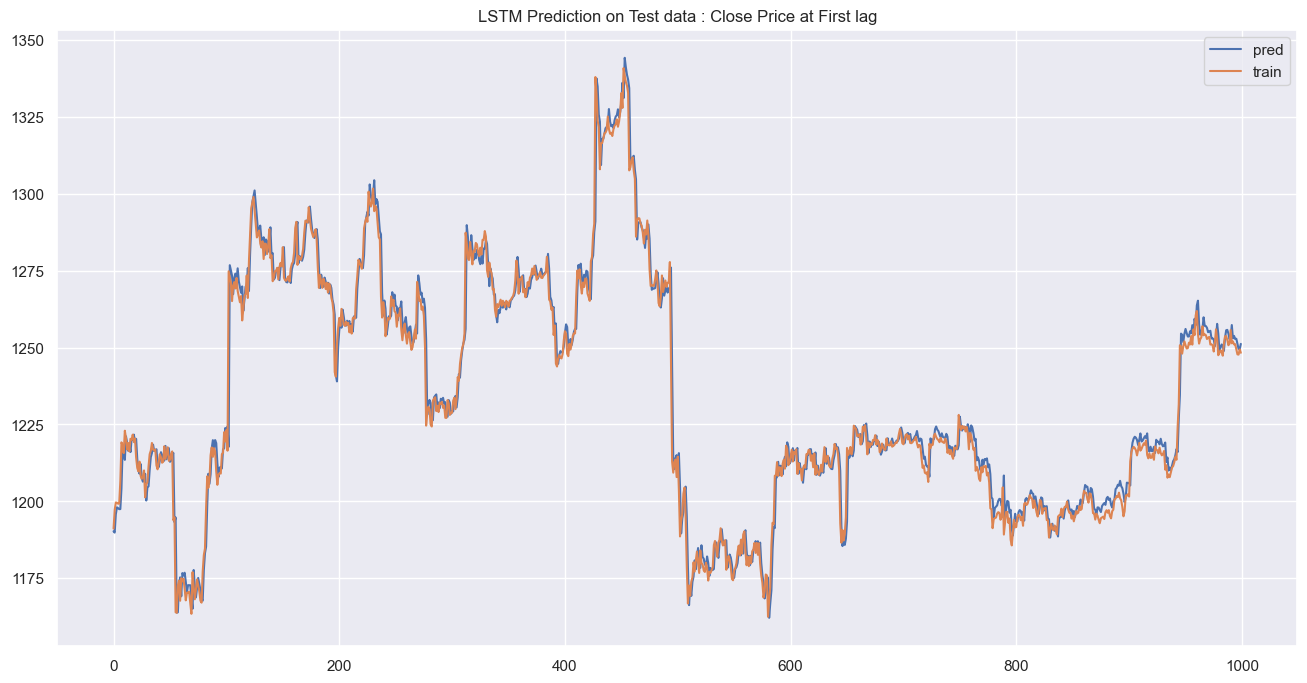

In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw_1[:1000,0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

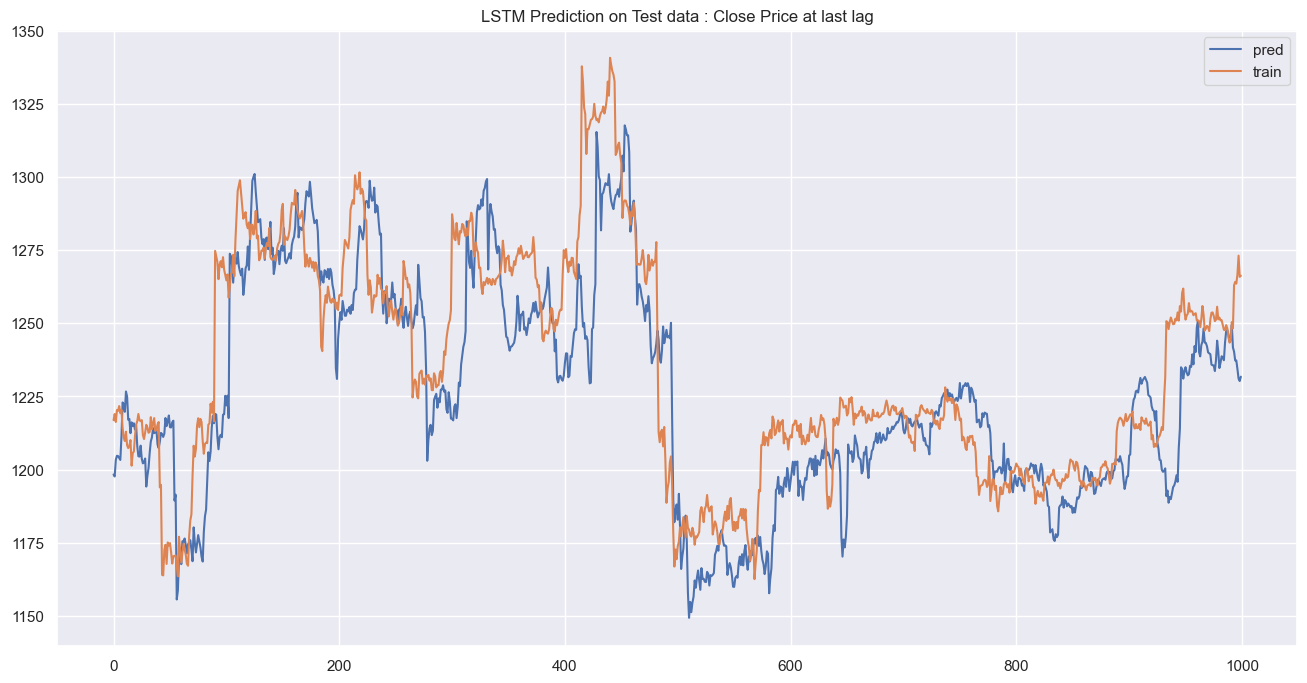

In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw_1[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

In [ ]:
y_train_pred_unscaled_1[0,:]

array([1.0009207, 1.0042758, 0.9999173, 1.0048245, 1.0018502, 1.0111582,
       1.008578 , 1.011359 , 1.0074592, 1.0124773, 1.0124305, 1.0012397,
       1.0230651], dtype=float32)

In [ ]:
y_train_pred_unscaled_1[0,:] * X_train_raw[0,-1, 0]

array([2207.6907, 2215.0908, 2205.4775, 2216.3013, 2209.741 , 2230.2712,
       2224.5798, 2230.7139, 2222.1123, 2233.1807, 2233.0774, 2208.3943,
       2256.5337], dtype=float32)

In [ ]:
y_train_pred_raw_1[0,:]

array([2207.69064825, 2215.09095838, 2205.47765447, 2216.30124892,
       2209.74101664, 2230.271257  , 2224.58002542, 2230.71403981,
       2222.11237893, 2233.18063456, 2233.07756397, 2208.39426275,
       2256.53374681])

### Autoencoder + LSTM reduced features

In [ ]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

In [ ]:
X_train[:,:,0:4].shape

(12174, 48, 4)

In [ ]:
list_col_select[0:4]

['Close_ETH', 'Open_ETH', 'High_ETH', 'Low_ETH']

Concatenate 

In [ ]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

  1/381 [..............................] - ETA: 1:43

2023-04-01 12:48:50.973164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-01 12:48:51.032678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


381/381 [==============================] - 3s 8ms/step


(12174, 48, 8)

In [ ]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

94/94 [==============================] - 1s 8ms/step


(2997, 48, 8)

In [ ]:
# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(X_train_encoded.reshape(-1,X_train_encoded.shape[-1])).reshape(X_train_encoded.shape)
X_test_encoded_sca = scaler_enc.transform(X_test_encoded.reshape(-1,X_test_encoded.shape[-1])).reshape(X_test_encoded.shape)

In [ ]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((12174, 48, 12), (2997, 48, 12))

Train

In [ ]:
NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 100
patience = 10
dropout_rate = 0.2
tf.keras.backend.clear_session()
tf.random.set_seed(0)
# optimizer def 
#optim = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
#                      nesterov=nesterov)
optim = tf.optimizers.Adam()
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                verbose=1, patience=patience,
                                restore_best_weights=True)
# create model
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(64, 
                    return_sequences=False,
                    input_shape=X_train_.shape[-2:]))
multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
#multi_step_model.add(tf.keras.layers.BatchNormalization())
multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
# compile
multi_step_model.compile(optimizer=optim, loss='mse')
# fitting
'''multi_step_history = multi_step_model.fit(X_train_sca, 
                                        epochs=EPOCHS,
                                        steps_per_epoch=EVALUATION_INTERVAL,
                                        validation_data=val_data_multi,
                                        validation_steps=1,
                                        callbacks=[es],
                                        verbose=0)'''

multi_step_history = multi_step_model.fit(
    X_train_, y_train_sca, epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(X_test_, y_test_sca), 
    verbose=1, 
    callbacks=[es]
)
# eval
mse_curr = np.min(multi_step_history.history['val_loss'])
mse_curr

Epoch 1/100


2023-04-01 12:48:56.183007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-01 12:48:56.344437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  5/381 [..............................] - ETA: 6s - loss: 1.0200  

2023-04-01 12:48:56.441741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


381/381 [==============================] - ETA: 0s - loss: 1.0063

2023-04-01 12:49:02.528232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-01 12:49:02.588107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


381/381 [==============================] - 8s 18ms/step - loss: 1.0063 - val_loss: 0.4300
Epoch 2/100
381/381 [==============================] - 6s 17ms/step - loss: 0.9817 - val_loss: 0.4471
Epoch 3/100
381/381 [==============================] - 7s 17ms/step - loss: 0.9621 - val_loss: 0.5147
Epoch 4/100
381/381 [==============================] - 7s 18ms/step - loss: 0.9283 - val_loss: 0.4834
Epoch 5/100
381/381 [==============================] - 6s 17ms/step - loss: 0.8799 - val_loss: 0.5365
Epoch 6/100
381/381 [==============================] - 6s 17ms/step - loss: 0.8146 - val_loss: 0.5962
Epoch 7/100
381/381 [==============================] - 6s 17ms/step - loss: 0.7517 - val_loss: 0.5803
Epoch 8/100
381/381 [==============================] - 6s 17ms/step - loss: 0.6888 - val_loss: 0.5993
Epoch 9/100
381/381 [==============================] - 6s 17ms/step - loss: 0.6290 - val_loss: 0.7382
Epoch 10/100
381/381 [==============================] - 6s 17ms/step - loss: 0.5853 - val_loss

0.43001413345336914

### Results

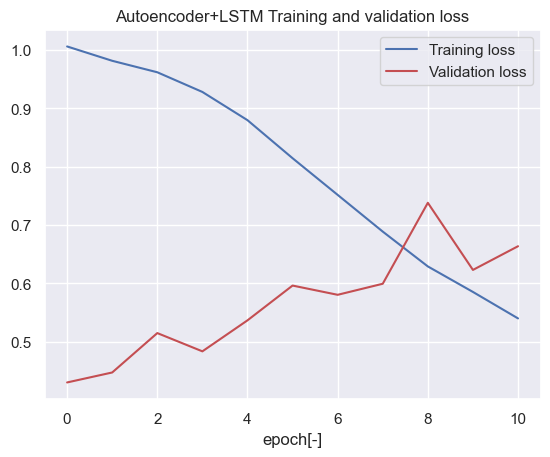

In [ ]:
plot_train_history(multi_step_history,
                       'Autoencoder+LSTM Training and validation loss')

Save mdl

In [ ]:
multi_step_model.save(path_mdl_predict_autoenc_lstm)

INFO:tensorflow:Assets written to: data/mdl_predict_autoenc_lstm/assets


Predict

In [ ]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(y_test_pred.reshape(-1,y_test_pred.shape[-1])).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

  8/381 [..............................] - ETA: 2s  

2023-04-01 12:50:11.938213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-01 12:50:11.994931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 1s 7ms/step


Plots

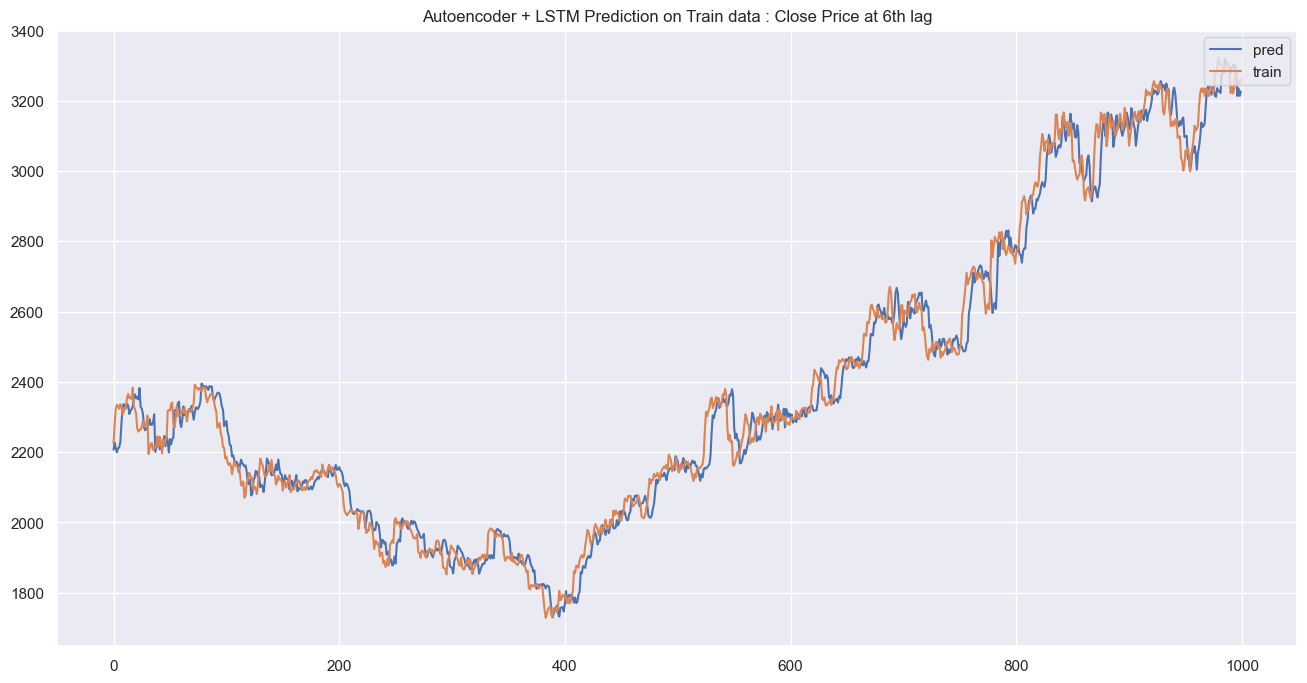

In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder + LSTM Prediction on Train data : Close Price at 6th lag")
plt.plot(y_train_pred_raw[:1000, 5], label="pred")
plt.plot(y_train_raw[:1000, 5], label="train")
plt.legend(loc='upper right')

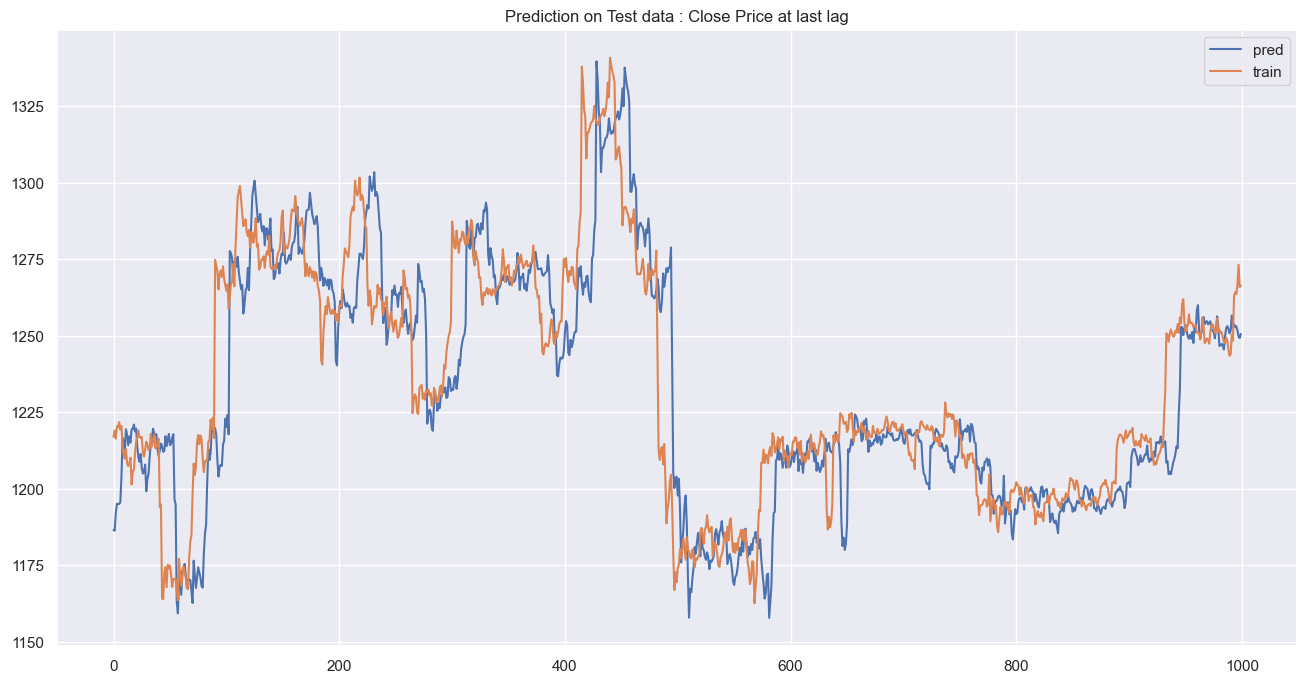

In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

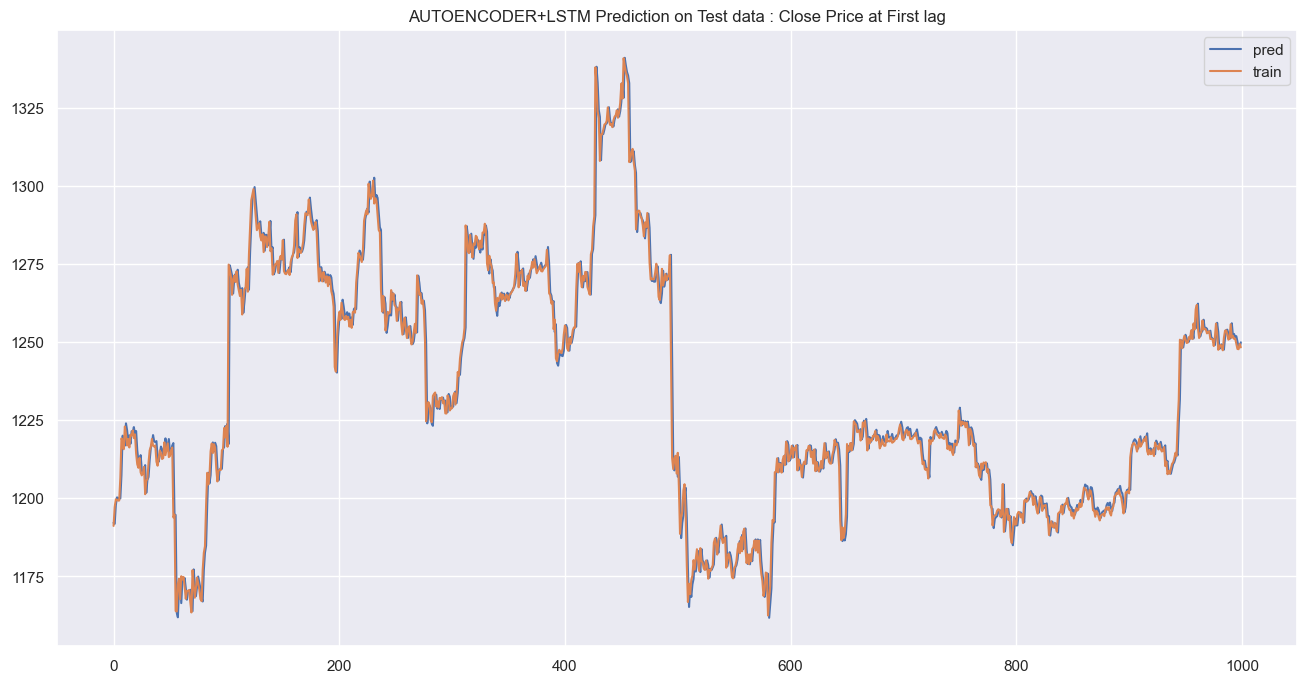

In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

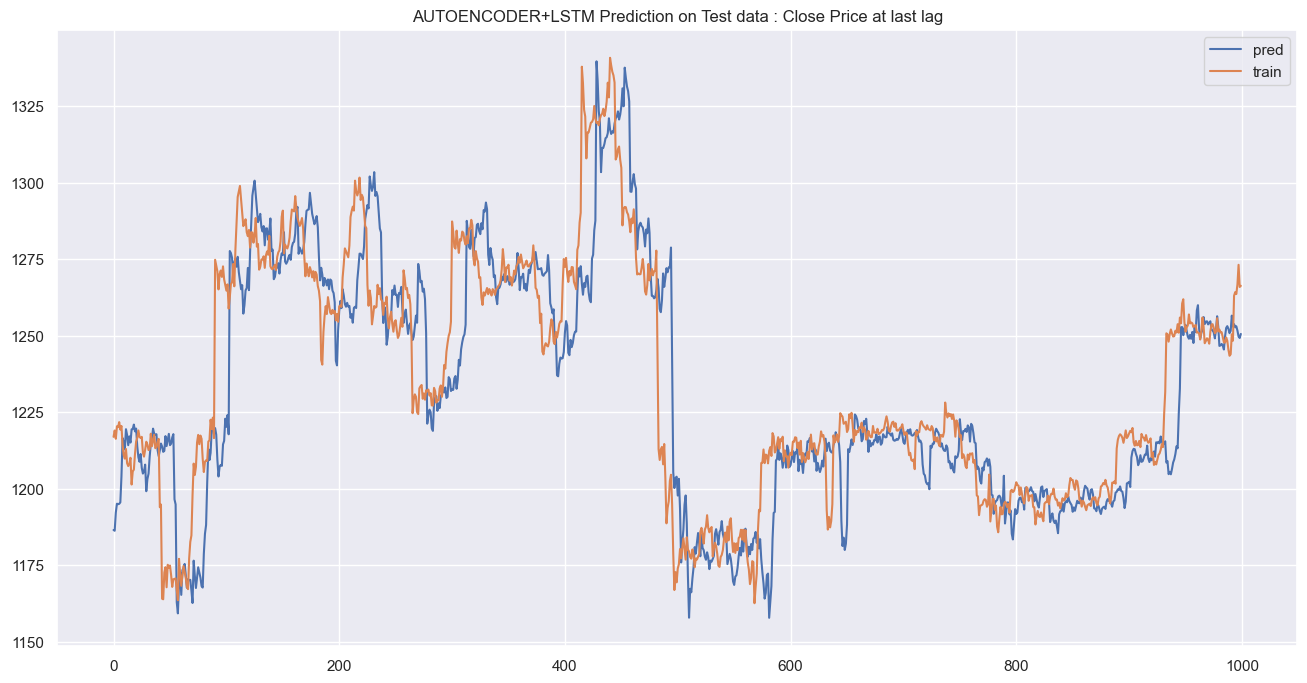

In [ ]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

In [ ]:
str(time.time())

'1680321016.398447'

## Save best prediction

In [ ]:
X_test_sca.shape

(2997, 48, 104)

In [ ]:
df_feat["Close_ETH"].iloc[-1]

1802.65

In [ ]:
multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)

In [ ]:
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]

In [ ]:
X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]

In [ ]:
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)

In [ ]:
X_last_sca.shape

(1, 48, 104)

In [ ]:
X_last_sca = X_last_sca[:,:,:4]

In [ ]:
X_last_sca.shape

(1, 48, 4)

In [ ]:
y_last_pred = multi_step_model.predict(X_last_sca)

ValueError: in user code:

    File "/Users/gregory/miniforge3/envs/ocean_tf/lib/python3.10/site-packages/keras/engine/training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "/Users/gregory/miniforge3/envs/ocean_tf/lib/python3.10/site-packages/keras/engine/training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/gregory/miniforge3/envs/ocean_tf/lib/python3.10/site-packages/keras/engine/training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/gregory/miniforge3/envs/ocean_tf/lib/python3.10/site-packages/keras/engine/training.py", line 1791, in predict_step
        return self(x, training=False)
    File "/Users/gregory/miniforge3/envs/ocean_tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/gregory/miniforge3/envs/ocean_tf/lib/python3.10/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 48, 12), found shape=(None, 48, 4)


In [ ]:
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
# divided price
X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
# scaler
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
y_last_pred = multi_step_model_1.predict(X_last_sca)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
y_last_pred_raw

1/1 [==============================] - 0s 297ms/step


2023-02-20 00:45:44.962785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 00:45:45.025678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[1676.4545, 1672.0531, 1680.8876, 1667.468 , 1670.1584, 1678.7974,
        1662.3367, 1662.5453, 1684.7573, 1659.3712, 1654.6205, 1691.6415,
        1637.5485]], dtype=float32)

In [ ]:
#file_name = "/tmp/pred_vals.csv"
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
save_list(list_pred, path_save_pred_vals)